Все новое - это хорошо забытое старое

In [28]:
! pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import os
# Ensure TF specific env vars are set before TF import
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Filter out INFO and WARNING logs

import numpy as np
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm # tqdm can be uncommented if progress bar is needed
import traceback
from sklearn.preprocessing import MinMaxScaler
from scipy.fft import fft
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt



data prep

In [30]:
def add_technical_indicators(df_company_group):
    df_company_group = df_company_group.copy()
    
    # Преобразование 'begin' в datetime (если еще не выполнено)
    df_company_group['begin'] = pd.to_datetime(df_company_group['begin'])
    
    # Установка 'begin' как индекса для восстановления недостающих дат
    df_company_group = df_company_group.set_index('begin')
    
    # Генерация полного диапазона дат для текущей группы
    full_date_range = pd.date_range(
        start=df_company_group.index.min(),
        end=df_company_group.index.max(),
        freq='D'
    )
    
    # Восстановление недостающих дат (вставка NaN для новых строк)
    df_company_group = df_company_group.reindex(full_date_range)
    
    # Заполнение пропусков:
    # - Ценовые метрики (open, high, low, close) заполняются последними известными значениями (forward-fill)
    # - Объемы (volume, value) и рыночные метрики заполняются нулями
    price_cols = ['open', 'high', 'low', 'close', 'market_open', 'market_close_pred', 'market_high', 'market_low']
    fill_zero_cols = ['volume', 'value', 'market_volume', 'market_value']
    
    for col in price_cols:
        if col in df_company_group.columns:
            df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
    
    for col in fill_zero_cols:
        if col in df_company_group.columns:
            df_company_group[col] = df_company_group[col].fillna(0)  # Заполнение нулями
    
    # Восстановление 'begin' как столбца
    df_company_group = df_company_group.reset_index().rename(columns={'index': 'begin'})
    
    # Перерасчет временных признаков (sin/cos) для новых дат
    df_company_group['day_sin'] = np.sin(2 * np.pi * df_company_group['begin'].dt.dayofweek / 7)
    df_company_group['day_cos'] = np.cos(2 * np.pi * df_company_group['begin'].dt.dayofweek / 7)
    df_company_group['hour_sin'] = np.sin(2 * np.pi * df_company_group['begin'].dt.hour / 24)
    df_company_group['hour_cos'] = np.cos(2 * np.pi * df_company_group['begin'].dt.hour / 24)
    
    # Остальные преобразования (оригинальный код)
    for col in ['high', 'low', 'open', 'volume']:
        if col in df_company_group.columns:
            df_company_group[col] = pd.to_numeric(df_company_group[col], errors='coerce')
    
    ti_base_cols = ['open', 'high', 'low', 'volume']
    for col in ti_base_cols:
        if col in df_company_group.columns:
            if df_company_group[col].isnull().all():
                df_company_group[col] = 0
                
    df_company_group['mean_10'] = df_company_group['open'].rolling(window=10).mean()
    df_company_group['mean_30'] = df_company_group['open'].rolling(window=50).mean()
    df_company_group['mean_50'] = df_company_group['open'].rolling(window=50).mean()

    # features volum
    df_company_group['volume_mean_10'] = df_company_group['volume'].rolling(window=10).mean()
    df_company_group['volume_mean_50'] = df_company_group['volume'].rolling(window=50).mean()
    df_company_group['volume_mean_15'] = df_company_group['volume'].rolling(window=15).mean()
    df_company_group['volume_mean_30'] = df_company_group['volume'].rolling(window=30).mean()
    df_company_group['volume_var_10'] = df_company_group['volume'].rolling(window=10).var()
    df_company_group['volume_var_50'] = df_company_group['volume'].rolling(window=50).var()
    df_company_group['volume_var_5'] = df_company_group['volume'].rolling(window=5).var()
    df_company_group['volume_var_15'] = df_company_group['volume'].rolling(window=15).var()

    #features value
    df_company_group['value_mean_10'] = df_company_group['value'].rolling(window=10).mean()
    df_company_group['value_mean_50'] = df_company_group['value'].rolling(window=50).mean()
    df_company_group['value_mean_15'] = df_company_group['value'].rolling(window=15).mean()
    df_company_group['value_mean_30'] = df_company_group['value'].rolling(window=30).mean()
    df_company_group['value_var_10'] = df_company_group['value'].rolling(window=10).var()
    df_company_group['value_var_50'] = df_company_group['value'].rolling(window=50).var()
    df_company_group['value_var_5'] = df_company_group['value'].rolling(window=5).var()
    df_company_group['value_var_15'] = df_company_group['value'].rolling(window=15).var()

    # features close без учета текущего дня
    df_company_group['close_mean_5'] = df_company_group['close'].shift(1).rolling(window=5).mean()
    df_company_group['close_var_5'] = df_company_group['close'].shift(1).rolling(window=5).var()
    df_company_group['close_mean_15'] = df_company_group['close'].shift(1).rolling(window=15).mean()
    df_company_group['close_var_15'] = df_company_group['close'].shift(1).rolling(window=15).var()
    df_company_group['close_mean_7'] = df_company_group['close'].shift(1).rolling(window=7).mean()
    df_company_group['close_var_7'] = df_company_group['close'].shift(1).rolling(window=7).var()
    df_company_group['close_mean_30'] = df_company_group['close'].shift(1).rolling(window=30).mean()
    df_company_group['close_var_30'] = df_company_group['close'].shift(1).rolling(window=30).var()
    
    # features open
    df_company_group['open_mean_5'] = df_company_group['open'].rolling(window=5).mean()
    df_company_group['open_var_5'] = df_company_group['open'].rolling(window=5).var()
    df_company_group['open_mean_7'] = df_company_group['open'].rolling(window=7).mean()
    df_company_group['open_var_7'] = df_company_group['open'].rolling(window=7).var()
    df_company_group['open_mean_30'] = df_company_group['open'].rolling(window=30).mean()
    df_company_group['open_var_30'] = df_company_group['open'].rolling(window=30).var()
    
    # features high и low с shift(1)
    df_company_group['high'] = df_company_group['high'].shift(1)
    df_company_group['low'] = df_company_group['low'].shift(1)

    # лаг по дням
    for lag in [1,5, 14, 15, 30]:
        df_company_group[f'volume_lag_{lag}'] = df_company_group['volume'].shift(lag)
        df_company_group[f'value_lag_{lag}'] = df_company_group['value'].shift(lag)



    # Rolling-фичи для рыночных показателей
    df_company_group['market_volume_ma10'] = df_company_group['market_volume'].shift(1).rolling(10).mean()
    df_company_group['market_value_ma10'] = df_company_group['market_value'].shift(1).rolling(10).mean()
    df_company_group['market_open_ma30'] = df_company_group['market_open'].shift(1).rolling(30).mean()
    
    # Отношение показателей компании к рыночным
    df_company_group['volume_vs_market'] = df_company_group['volume'] / df_company_group['market_volume']
    df_company_group['value_vs_market'] = df_company_group['value'] / df_company_group['market_value']
    
    # Разница между ценой открытия и рыночной
    df_company_group['open_vs_market'] = df_company_group['open'] - df_company_group['market_open']
    df_company_group['open_vs_market_ma5'] = df_company_group['open_vs_market'].rolling(5).mean()
    
    # Лаги рыночных показателей
    for lag in [1, 5, 14]:
        df_company_group[f'market_volume_lag_{lag}'] = df_company_group['market_volume'].shift(lag)
        df_company_group[f'market_open_lag_{lag}'] = df_company_group['market_open'].shift(lag)
    
    # Корреляция объема компании с рыночным (30 дней)
    df_company_group['volume_market_corr_30'] = df_company_group['volume'].rolling(30).corr(df_company_group['market_volume'])
    
    # Относительная волатильность 
    df_company_group['volatility_ratio_30'] = (
        df_company_group['close'].shift(1).rolling(30).std() / 
        df_company_group['market_close_pred'].shift(1).rolling(30).std()
    )
    
    # Обработка бесконечных значений и пропусков
    df_company_group.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_company_group.fillna(0, inplace=True)
    
    df_company_group.dropna(inplace=True)
    df_company_group['target'] = df_company_group['close']
    df_company_group.drop(columns=['close'], inplace=True)
    
    return df_company_group

# Загрузка и предобработка данных
df = pd.read_parquet('../data/moex_new_features.parquet')
df['begin'] = pd.to_datetime(df['begin'])
df['end'] = pd.to_datetime(df['end'])
df = df.sort_values('begin')
print(df.columns)

market_agg = df.groupby('begin').agg({
    'volume': 'sum',
    'value': 'sum',
    'open': 'mean',
    'close': 'mean',
    'high': 'max',
    'low': 'min'
}).reset_index()
market_agg.columns = ['begin', 'market_volume', 'market_value', 'market_open', 'market_close_pred', 'market_high', 'market_low']
df = df.merge(market_agg, on='begin', how='left')

df['day_sin'] = np.sin(2 * np.pi * df['begin'].dt.dayofweek / 7)
df['day_cos'] = np.cos(2 * np.pi * df['begin'].dt.dayofweek / 7)
df['hour_sin'] = np.sin(2 * np.pi * df['begin'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['begin'].dt.hour / 24)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

dfs = []
for df_type in set(df.company):
    dfs.append(df[df['company'] == df_type].drop(columns=['company']))


Index(['open', 'close', 'high', 'low', 'value', 'volume', 'begin', 'end',
       'company'],
      dtype='object')


In [31]:

# Применение функции к данным
test = add_technical_indicators(dfs[0])
test

C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


,begin,open,high,low,value,volume,end,market_volume,market_value,market_open,...,open_vs_market_ma5,market_volume_lag_1,market_open_lag_1,market_volume_lag_5,market_open_lag_5,market_volume_lag_14,market_open_lag_14,volume_market_corr_30,volatility_ratio_30,target
0,2023-01-03 09:00:00,4082.0,0.0,0.0,8629348.0,2114.0,2023-01-03 09:59:59,115561863.0,2.721688e+07,1231.137500,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4082.0
1,2023-01-04 09:00:00,4124.0,4082.0,4082.0,3971412.0,963.0,2023-01-04 09:59:59,22896788.0,1.658798e+07,1245.005000,...,0.000000,115561863.0,1231.137500,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4124.0
2,2023-01-05 09:00:00,4121.5,4124.0,4124.0,3416723.5,829.0,2023-01-05 09:59:59,26121094.0,7.962705e+06,1244.045833,...,0.000000,22896788.0,1245.005000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4121.5
3,2023-01-06 09:00:00,4088.0,4121.5,4121.5,1103760.0,270.0,2023-01-06 09:59:59,9708264.0,4.354444e+06,1236.227500,...,0.000000,26121094.0,1244.045833,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4088.0
4,2023-01-07 09:00:00,4088.0,4088.0,4088.0,0.0,0.0,0,0.0,0.000000e+00,1236.227500,...,2862.171333,9708264.0,1236.227500,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4088.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,2025-03-13 09:00:00,7186.0,7241.0,7212.0,226719325.5,31616.0,2025-03-13 09:59:59,12429145.0,2.987284e+09,1949.180000,...,5255.694667,4383515.0,1954.363333,0.0,1954.763333,17869971.0,1988.698333,0.774391,4.411968,7167.0
801,2025-03-14 09:00:00,7132.5,7188.0,7150.5,122579782.5,17161.0,2025-03-14 09:59:59,6632993.0,1.674402e+09,1934.728333,...,5242.701667,12429145.0,1949.180000,0.0,1954.763333,7737626.0,1981.990000,0.774802,4.665879,7142.0
802,2025-03-15 09:00:00,7163.0,7148.0,7129.0,286520.0,40.0,2025-03-15 09:59:59,62339.0,1.106551e+07,1952.453333,...,5227.909000,6632993.0,1934.728333,5415200.0,1968.990000,0.0,1981.990000,0.907655,4.881010,7163.0
803,2025-03-16 09:00:00,7170.0,7163.0,7163.0,1627590.0,227.0,2025-03-16 09:59:59,12086.0,7.171072e+06,1955.091667,...,5223.536667,62339.0,1952.453333,5480659.0,1951.730000,87490.0,1996.168333,0.856381,4.937576,7170.0


In [32]:
test.columns

Index(['begin', 'open', 'high', 'low', 'value', 'volume', 'end',
       'market_volume', 'market_value', 'market_open', 'market_close_pred',
       'market_high', 'market_low', 'day_sin', 'day_cos', 'hour_sin',
       'hour_cos', 'mean_10', 'mean_30', 'mean_50', 'volume_mean_10',
       'volume_mean_50', 'volume_mean_15', 'volume_mean_30', 'volume_var_10',
       'volume_var_50', 'volume_var_5', 'volume_var_15', 'value_mean_10',
       'value_mean_50', 'value_mean_15', 'value_mean_30', 'value_var_10',
       'value_var_50', 'value_var_5', 'value_var_15', 'close_mean_5',
       'close_var_5', 'close_mean_15', 'close_var_15', 'close_mean_7',
       'close_var_7', 'close_mean_30', 'close_var_30', 'open_mean_5',
       'open_var_5', 'open_mean_7', 'open_var_7', 'open_mean_30',
       'open_var_30', 'volume_lag_1', 'value_lag_1', 'volume_lag_5',
       'value_lag_5', 'volume_lag_14', 'value_lag_14', 'volume_lag_15',
       'value_lag_15', 'volume_lag_30', 'value_lag_30', 'market_volume_ma10

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 1029.82
[20]	valid_0's huber: 892.383
[30]	valid_0's huber: 840.435
[40]	valid_0's huber: 813.662
[50]	valid_0's huber: 799.145
[60]	valid_0's huber: 789.411
[70]	valid_0's huber: 784.292
[80]	valid_0's huber: 780.143
[90]	valid_0's huber: 776.443
[100]	valid_0's huber: 773.853
[110]	valid_0's huber: 771.097
[120]	valid_0's huber: 769.404
[130]	valid_0's huber: 767.929
[140]	valid_0's huber: 766.676
[150]	valid_0's huber: 765.556
[160]	valid_0's huber: 764.649
[170]	valid_0's huber: 763.934
[180]	valid_0's huber: 763.539
[190]	valid_0's huber: 762.928
[200]	valid_0's huber: 762.534
[210]	valid_0's huber: 762.295
[220]	valid_0's huber: 762.015
[230]	valid_0's huber: 761.801
[240]	valid_0's huber: 761.537
[250]	valid_0's huber: 761.35
[260]	valid_0's huber: 761.208
[270]	valid_0's huber: 761.076
[280]	valid_0's huber: 760.926
[290]	valid_0's h

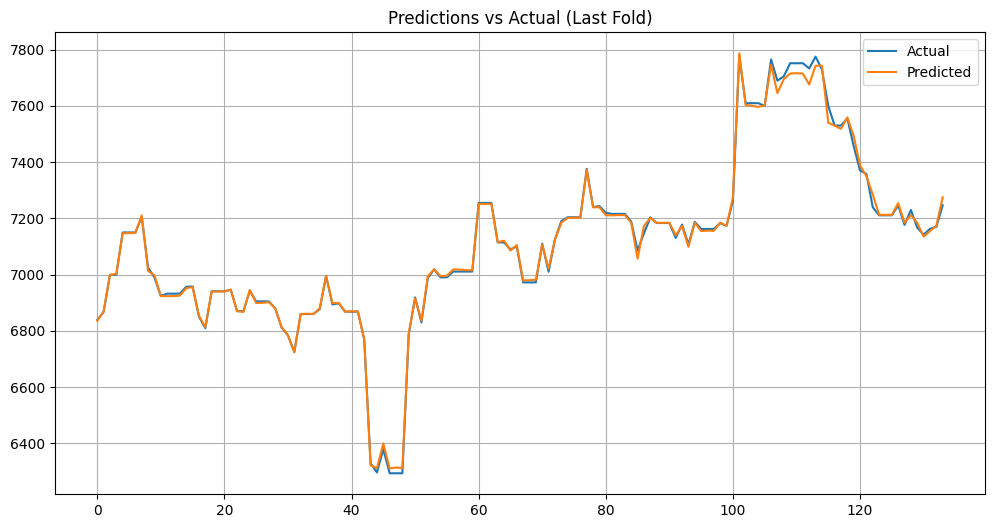

<Figure size 1200x800 with 0 Axes>

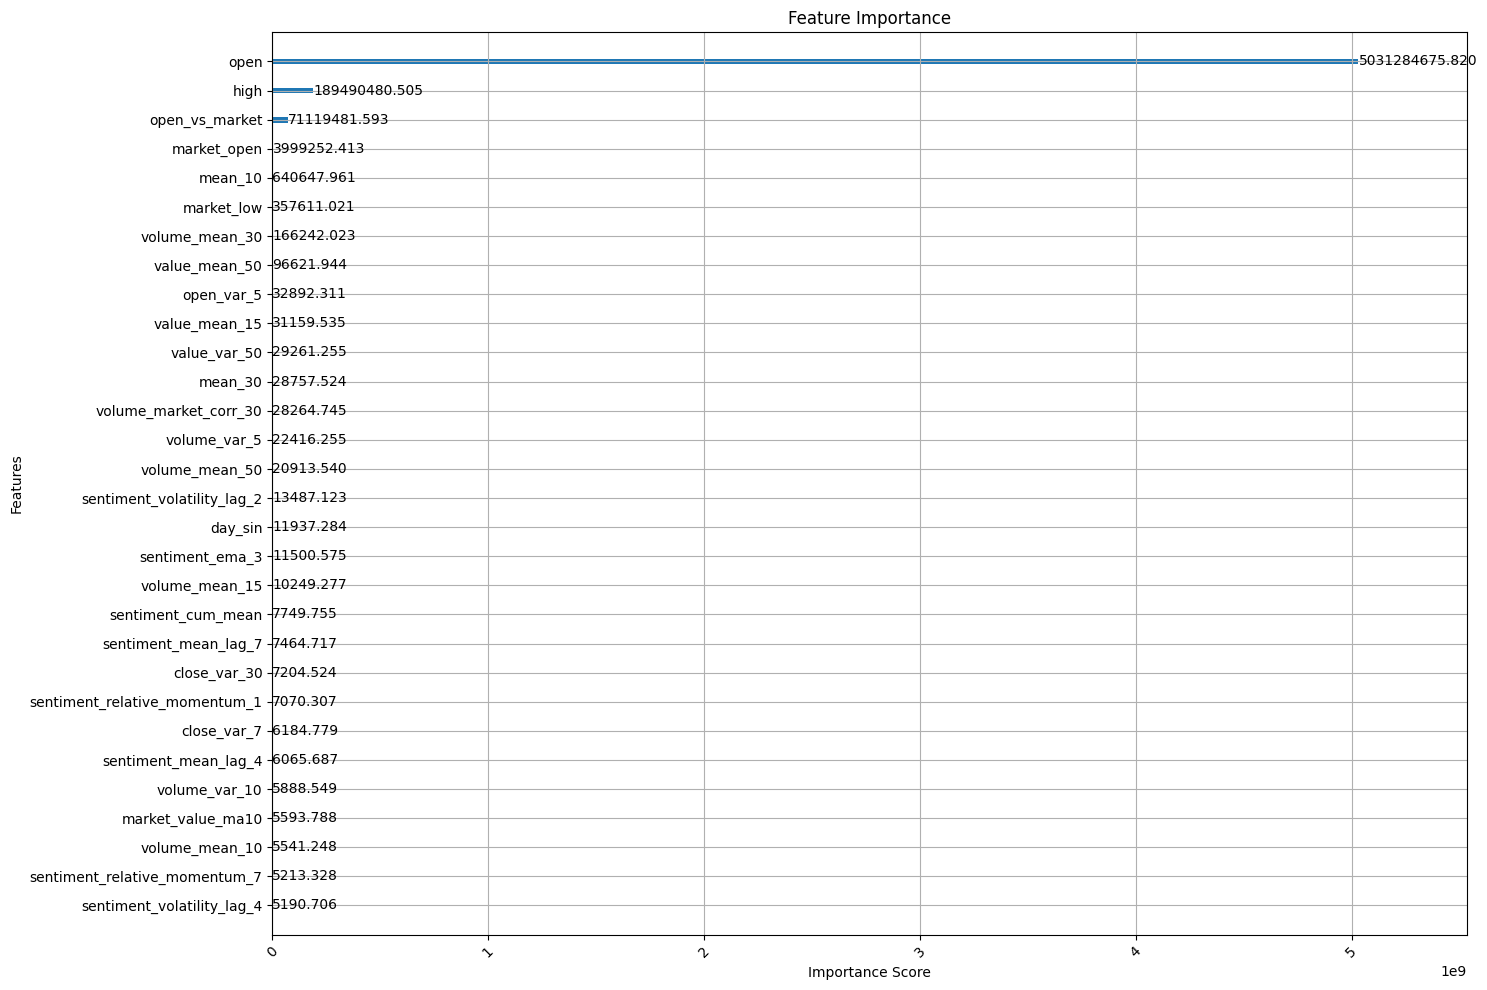

In [39]:
from sklearn.model_selection import GridSearchCV
import joblib
import os

def train_and_evaluate_model(df):
    # Проверка данных (оставляем без изменений)
    try:
        df_processed = df.copy()
        cols_to_drop = ['date', 'begin', 'end']
        cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
        df_processed.drop(columns=cols_to_drop, inplace=True)
        
        datetime_cols = df_processed.select_dtypes(include=['datetime64', 'datetimetz']).columns
        for col in datetime_cols:
            df_processed[col] = df_processed[col].astype(np.int64) // 10**9
        
        if 'target' not in df_processed.columns:
            raise ValueError("Целевая переменная 'target' отсутствует в данных")
            
        X = df_processed.drop('target', axis=1)
        y = df_processed['target']
        
        non_numeric = X.select_dtypes(exclude=['number']).columns
        if len(non_numeric) > 0:
            X[non_numeric] = X[non_numeric].astype('category')

    except Exception as e:
        raise ValueError(f"Ошибка подготовки данных: {str(e)}")

    # Feature Selection (оставляем без изменений)
    base_model = lgb.LGBMRegressor(
        objective='regression',
        metric='huber',
        verbosity=-1,
        n_estimators=400,
        random_state=42
    )
    base_model.fit(X, y)
    importance = base_model.feature_importances_
    selected_features = X.columns
    X_selected = X[selected_features]

    # Добавляем Grid Search для настройки гиперпараметров 
    param_grid = {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [15, 31, 63],
        'min_child_samples': [5, 20, 50]
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        estimator=lgb.LGBMRegressor(
            objective='regression', 
            metric='huber', 
            verbosity=-1, 
            random_state=42
        ),
        param_grid=param_grid,
        cv=tscv.split(X_selected, y),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_selected, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Сохраняем лучшую модель [[10]]
    os.makedirs('models', exist_ok=True)
    joblib.dump(best_model, 'models/best_model.pkl')

    # Используем лучшие параметры в кросс-валидации
    scores = {
        'MAE': [],
        'MSE': [],
        'RMSE': [],
        'R2': [],
        'MAPE': [],
        'SignAccuracy': []  # \метрика: процент совпадающих знаков
    }
    last_fold_data = {}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_selected)):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = lgb.LGBMRegressor(
            objective='regression',
            metric='huber',
            verbosity=-1,
            random_state=42,
            **best_params 
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=10)
            ]
        )
        
        y_pred = model.predict(X_val)

        # Вычисление процента совпадающих знаков
        sign_matches = np.sign(y_val) == np.sign(y_pred)  # Сравнение знаков
        sign_accuracy = np.mean(sign_matches) * 100       # Переводим в проценты
        scores['SignAccuracy'].append(sign_accuracy)      # Сохраняем результат
        scores['MAE'].append(mean_absolute_error(y_val, y_pred))
        scores['MAPE'].append(mean_absolute_percentage_error(y_val, y_pred))
        scores['MSE'].append(mean_squared_error(y_val, y_pred))
        scores['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
        scores['R2'].append(r2_score(y_val, y_pred))
        
        if fold == tscv.n_splits - 1:
            last_fold_data = {
                'y_val': y_val,
                'y_pred': y_pred,
                'model': model
            }
    print("\nлучшие метрики")
    print(f"MAE: {np.min(scores['MAE'])} ")
    print(f"MAPE: {np.min(scores['MAPE'])}")
    print(f"MSE: {np.min(scores['MSE'])}")
    print(f"RMSE: {np.min(scores['RMSE'])} ")
    print(f"R² Score: {np.max(scores['R2'])}")
    print(f"Sign Accuracy: {np.max(scores['SignAccuracy'])}%")  
    
    if last_fold_data:
        plt.figure(figsize=(12, 6))
        plt.plot(last_fold_data['y_val'].values, label='Actual')
        plt.plot(last_fold_data['y_pred'], label='Predicted')
        plt.title('Predictions vs Actual (Last Fold)')
        plt.legend()
        plt.grid()
        plt.show()
                
              
        plt.figure(figsize=(12, 8))  
        ax = lgb.plot_importance(
            last_fold_data['model'],
            max_num_features=30,  
            importance_type='gain',  
            figsize=(15, 10),  
            title='Feature Importance',
            xlabel='Importance Score',
            ylabel='Features'
        )
        plt.xticks(rotation=45)  
        plt.tight_layout() 
        plt.show()
    
    return best_model, scores  

# Вызов функции
model, scores = train_and_evaluate_model(test)

Добавим в test метрику сентимента

In [34]:
import json

with open('../data/model_data/model_data_cache.json', 'r', encoding='utf-8') as f:
    sentiment_df = pd.DataFrame(json.load(f))
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['answer'] = sentiment_df['answer'].apply(int)
sentiment_df

,reasoning,answer,article_text,sphere,source,date
0,"Статья о финансовых результатах Rivian, америк...",15,Москва. 21 февраля. INTERFAX.RU - Американски...,Финансы,Интерфакс,2025-02-21
1,"Статья рассказывает о социальной акции ПАО ""Га...",0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Финансы,Интерфакс,2025-02-21
2,"Статья сообщает о значительном убытке ПАО ""Рас...",-75,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Финансы,Интерфакс,2025-02-21
3,,0,Москва. 21 февраля. INTERFAX.RU - Российский ...,Энергетика,Интерфакс,2025-02-21
4,"Статья фокусируется на динамике рубля и юаня, ...",25,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Энергетика,Интерфакс,2025-02-21
...,...,...,...,...,...,...
10708,Введение налогов на криптовалюты и регулирован...,-20,**Турция планирует ввести налоги на криптоакти...,Финансы/Энергетика,The Экономист,2024-05-12
10709,"Статья о проблемах в сельском хозяйстве, вызва...",25,**Российские фермеры и сельхозкомпании на гран...,Энергетика,The Экономист,2024-05-11
10710,Статья рассказывает о финансовой связи Романа ...,10,**Абрамович все еще влияет на футбол в условия...,Финансы,The Экономист,2024-05-11
10711,Статья описывает случай мошенничества с исполь...,-30,**Более 26 миллионов рублей пропало со счетов ...,Финансы,The Экономист,2024-05-10


In [35]:
test

,begin,open,high,low,value,volume,end,market_volume,market_value,market_open,...,open_vs_market_ma5,market_volume_lag_1,market_open_lag_1,market_volume_lag_5,market_open_lag_5,market_volume_lag_14,market_open_lag_14,volume_market_corr_30,volatility_ratio_30,target
0,2023-01-03 09:00:00,4082.0,0.0,0.0,8629348.0,2114.0,2023-01-03 09:59:59,115561863.0,2.721688e+07,1231.137500,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4082.0
1,2023-01-04 09:00:00,4124.0,4082.0,4082.0,3971412.0,963.0,2023-01-04 09:59:59,22896788.0,1.658798e+07,1245.005000,...,0.000000,115561863.0,1231.137500,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4124.0
2,2023-01-05 09:00:00,4121.5,4124.0,4124.0,3416723.5,829.0,2023-01-05 09:59:59,26121094.0,7.962705e+06,1244.045833,...,0.000000,22896788.0,1245.005000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4121.5
3,2023-01-06 09:00:00,4088.0,4121.5,4121.5,1103760.0,270.0,2023-01-06 09:59:59,9708264.0,4.354444e+06,1236.227500,...,0.000000,26121094.0,1244.045833,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4088.0
4,2023-01-07 09:00:00,4088.0,4088.0,4088.0,0.0,0.0,0,0.0,0.000000e+00,1236.227500,...,2862.171333,9708264.0,1236.227500,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4088.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,2025-03-13 09:00:00,7186.0,7241.0,7212.0,226719325.5,31616.0,2025-03-13 09:59:59,12429145.0,2.987284e+09,1949.180000,...,5255.694667,4383515.0,1954.363333,0.0,1954.763333,17869971.0,1988.698333,0.774391,4.411968,7167.0
801,2025-03-14 09:00:00,7132.5,7188.0,7150.5,122579782.5,17161.0,2025-03-14 09:59:59,6632993.0,1.674402e+09,1934.728333,...,5242.701667,12429145.0,1949.180000,0.0,1954.763333,7737626.0,1981.990000,0.774802,4.665879,7142.0
802,2025-03-15 09:00:00,7163.0,7148.0,7129.0,286520.0,40.0,2025-03-15 09:59:59,62339.0,1.106551e+07,1952.453333,...,5227.909000,6632993.0,1934.728333,5415200.0,1968.990000,0.0,1981.990000,0.907655,4.881010,7163.0
803,2025-03-16 09:00:00,7170.0,7163.0,7163.0,1627590.0,227.0,2025-03-16 09:59:59,12086.0,7.171072e+06,1955.091667,...,5223.536667,62339.0,1952.453333,5480659.0,1951.730000,87490.0,1996.168333,0.856381,4.937576,7170.0


In [ ]:
def add_sentiment_features(test_df, sentiment_df, scale_factor=1000):
    """
    Добавляет расширенные sentiment-признаки с разбивкой на финансовые и энергетические метрики
    
    Параметры:
    ----------
    test_df : pd.DataFrame
        Основной датафрейм с целевой переменной
    sentiment_df : pd.DataFrame
        Дадафрейм с sentiment-данными
    scale_factor : int, default=1000
        Множитель для масштабирования sentiment
        
    Возвращает:
    -----------
    pd.DataFrame
        Обогащенный датафрейм с новыми признаками
    """
    # 1. Предобработка дат
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
    test_df['date'] = pd.to_datetime(test_df['begin']).dt.date
    
    # 2. Агрегация sentiment статистик по сферам
    sentiment_stats = (
        sentiment_df[sentiment_df['sphere'].isin(['Финансы', 'Энергетика'])]
        .groupby(['date', 'sphere'])['answer']
        .agg(['median', 'mean', 'std', 'count', 'skew', 'min', 'max'])
        .reset_index()
    )
    
    # 3. Добавление новых метрик на основе агрегатов
    sentiment_stats['daily_range'] = sentiment_stats['max'] - sentiment_stats['min']
    sentiment_stats['cv'] = sentiment_stats['std'] / sentiment_stats['mean'].replace(0, 1e-8)
    sentiment_stats['extreme_positive'] = sentiment_stats['count'] * (sentiment_stats['mean'] > 0.8)
    sentiment_stats['extreme_negative'] = sentiment_stats['count'] * (sentiment_stats['mean'] < -0.8)
    
    # 4. Преобразование в wide формат с префиксами
    financial_stats = sentiment_stats[sentiment_stats['sphere'] == 'Финансы'].drop('sphere', axis=1)
    energetic_stats = sentiment_stats[sentiment_stats['sphere'] == 'Энергетика'].drop('sphere', axis=1)
    
    financial_stats.columns = ['date'] + [f'financial_{col}' for col in financial_stats.columns[1:]]
    energetic_stats.columns = ['date'] + [f'energetic_{col}' for col in energetic_stats.columns[1:]]
    
    # 5. Объединение с основным датафреймом
    test_df = test_df.merge(financial_stats, on='date', how='left')
    test_df = test_df.merge(energetic_stats, on='date', how='left')
    
    # 6. Масштабирование и переименование
    scale_cols = [
        'financial_median', 'financial_mean', 'financial_std', 
        'financial_daily_range', 'financial_cv',
        'energetic_median', 'energetic_mean', 'energetic_std',
        'energetic_daily_range', 'energetic_cv'
    ]
    
    for col in scale_cols:
        test_df[col] = test_df[col] * scale_factor
    
    # 7. Добавление временных признаков
    test_df = test_df.sort_values('date')
    
    # Относительный импульс (для обеих сфер)
    for prefix in ['financial', 'energetic']:
        test_df[f'{prefix}_relative_momentum_1'] = test_df[f'{prefix}_mean'].pct_change(1)
        test_df[f'{prefix}_relative_momentum_7'] = test_df[f'{prefix}_mean'].pct_change(7)
        
        # Скользящие средние
        windows = [3, 5, 7, 14]
        for window in windows:
            test_df[f'{prefix}_ma_{window}'] = test_df[f'{prefix}_mean'].rolling(window).mean()
            test_df[f'{prefix}_ema_{window}'] = test_df[f'{prefix}_mean'].ewm(span=window).mean()
        
        # Кумулятивные метрики
        test_df[f'{prefix}_cum_mean'] = test_df[f'{prefix}_mean'].expanding().mean()
        test_df[f'{prefix}_cum_std'] = test_df[f'{prefix}_mean'].expanding().std()
        
        # Тренды
        test_df[f'{prefix}_trend_7'] = test_df[f'{prefix}_mean'].rolling(7).apply(
            lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True
        )
        
        # Лаговые признаки
        lags = [1, 2, 3, 4, 5, 6, 7, 14]
        for lag in lags:
            test_df[f'{prefix}_mean_lag_{lag}'] = test_df[f'{prefix}_mean'].shift(lag)
            test_df[f'{prefix}_volatility_lag_{lag}'] = test_df[f'{prefix}_std'].shift(lag)
            
        # Волатильность волатильности
        test_df[f'{prefix}_volatility_of_volatility'] = test_df[f'{prefix}_std'].rolling(7).std() * scale_factor
        
        # Индикаторы настроения
        test_df[f'{prefix}_bullish_indicator'] = (
            test_df[f'{prefix}_mean'] > test_df[f'{prefix}_mean'].quantile(0.75)
        ).astype(int)
        
        test_df[f'{prefix}_bearish_indicator'] = (
            test_df[f'{prefix}_mean'] < test_df[f'{prefix}_mean'].quantile(0.25)
        ).astype(int)
    
    # 8. Обработка пропусков
    sentiment_cols = [col for col in test_df.columns if 'financial_' in col or 'energetic_' in col]
    test_df[sentiment_cols] = test_df[sentiment_cols].fillna(0)
    
    # 9. Удаление временных колонок
    if 'date' in test_df.columns:
        test_df = test_df.drop('date', axis=1)
    
    return test_df
test = add_sentiment_features(test, sentiment_df)


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_df[f'{prefix}_mean'].pct_change(1)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:65: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_7'] = test_df[f'{prefix}_mean'].pct_change(7)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non

In [42]:
test

,begin,open,high,low,value,volume,end,market_volume,market_value,market_open,...,energetic_volatility_lag_5,energetic_mean_lag_6,energetic_volatility_lag_6,energetic_mean_lag_7,energetic_volatility_lag_7,energetic_mean_lag_14,energetic_volatility_lag_14,energetic_volatility_of_volatility,energetic_bullish_indicator,energetic_bearish_indicator
0,2023-01-03 09:00:00,4082.0,0.0,0.0,8629348.0,2114.0,2023-01-03 09:59:59,115561863.0,2.721688e+07,1231.137500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,2023-01-04 09:00:00,4124.0,4082.0,4082.0,3971412.0,963.0,2023-01-04 09:59:59,22896788.0,1.658798e+07,1245.005000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,2023-01-05 09:00:00,4121.5,4124.0,4124.0,3416723.5,829.0,2023-01-05 09:59:59,26121094.0,7.962705e+06,1244.045833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,2023-01-06 09:00:00,4088.0,4121.5,4121.5,1103760.0,270.0,2023-01-06 09:59:59,9708264.0,4.354444e+06,1236.227500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,2023-01-07 09:00:00,4088.0,4088.0,4088.0,0.0,0.0,0,0.0,0.000000e+00,1236.227500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,2025-03-13 09:00:00,7186.0,7241.0,7212.0,226719325.5,31616.0,2025-03-13 09:59:59,12429145.0,2.987284e+09,1949.180000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
801,2025-03-14 09:00:00,7132.5,7188.0,7150.5,122579782.5,17161.0,2025-03-14 09:59:59,6632993.0,1.674402e+09,1934.728333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
802,2025-03-15 09:00:00,7163.0,7148.0,7129.0,286520.0,40.0,2025-03-15 09:59:59,62339.0,1.106551e+07,1952.453333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
803,2025-03-16 09:00:00,7170.0,7163.0,7163.0,1627590.0,227.0,2025-03-16 09:59:59,12086.0,7.171072e+06,1955.091667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 1036.61
[20]	valid_0's huber: 896.662
[30]	valid_0's huber: 841.29
[40]	valid_0's huber: 816.902
[50]	valid_0's huber: 802.802
[60]	valid_0's huber: 793.184
[70]	valid_0's huber: 789.021
[80]	valid_0's huber: 784.742
[90]	valid_0's huber: 782.341
[100]	valid_0's huber: 779.029
[110]	valid_0's huber: 777.458
[120]	valid_0's huber: 775.552
[130]	valid_0's huber: 774.278
[140]	valid_0's huber: 773.386
[150]	valid_0's huber: 772.176
[160]	valid_0's huber: 771.553
[170]	valid_0's huber: 770.947
[180]	valid_0's huber: 770.46
[190]	valid_0's huber: 770.086
[200]	valid_0's huber: 769.762
[210]	valid_0's huber: 769.496
[220]	valid_0's huber: 769.22
[230]	valid_0's huber: 769.059
[240]	valid_0's huber: 768.921
[250]	valid_0's huber: 768.812
[260]	valid_0's huber: 768.687
[270]	valid_0's huber: 768.608
[280]	valid_0's huber: 768.515
[290]	valid_0's hub

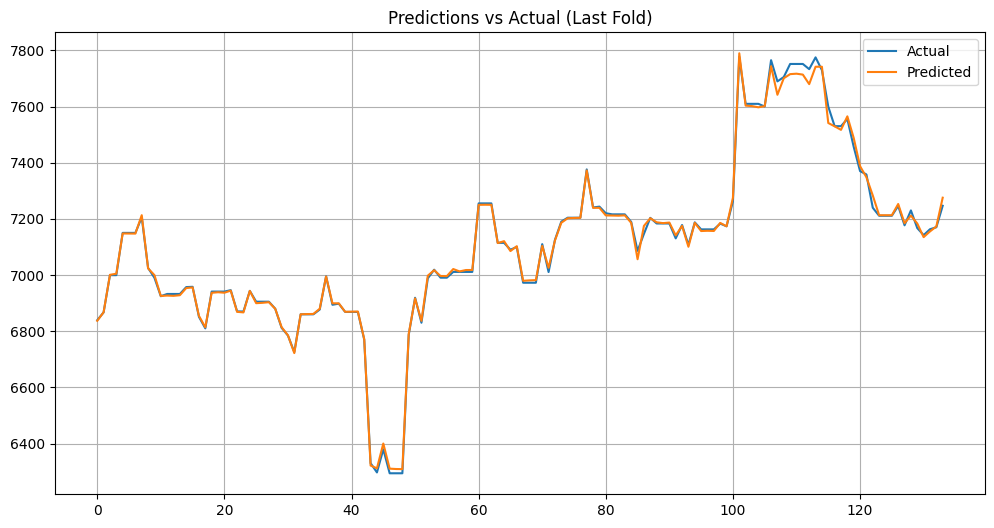

<Figure size 1200x800 with 0 Axes>

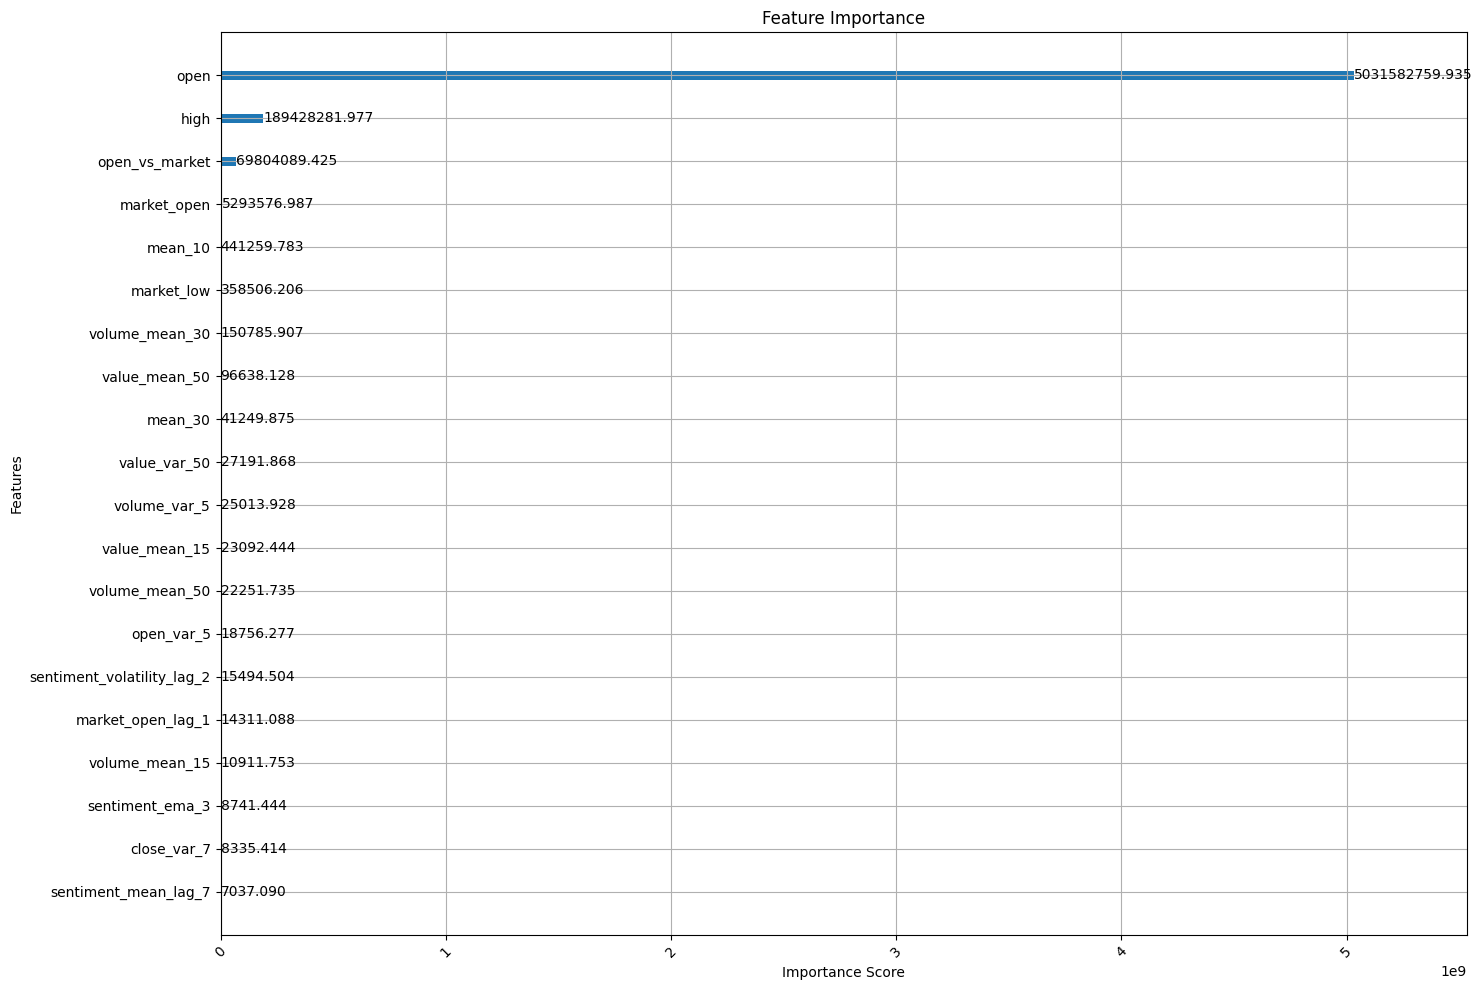

In [43]:
from sklearn.model_selection import GridSearchCV
import joblib
import os

def train_and_evaluate_model(df):
    # Проверка данных (оставляем без изменений)
    try:
        df_processed = df.copy()
        cols_to_drop = ['date', 'begin', 'end']
        cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
        df_processed.drop(columns=cols_to_drop, inplace=True)
        
        datetime_cols = df_processed.select_dtypes(include=['datetime64', 'datetimetz']).columns
        for col in datetime_cols:
            df_processed[col] = df_processed[col].astype(np.int64) // 10**9
        
        if 'target' not in df_processed.columns:
            raise ValueError("Целевая переменная 'target' отсутствует в данных")
            
        X = df_processed.drop('target', axis=1)
        y = df_processed['target']
        
        non_numeric = X.select_dtypes(exclude=['number']).columns
        if len(non_numeric) > 0:
            X[non_numeric] = X[non_numeric].astype('category')

    except Exception as e:
        raise ValueError(f"Ошибка подготовки данных: {str(e)}")

    # Feature Selection (оставляем без изменений)
    base_model = lgb.LGBMRegressor(
        objective='regression',
        metric='huber',
        verbosity=-1,
        n_estimators=400,
        random_state=42
    )
    base_model.fit(X, y)
    importance = base_model.feature_importances_
    selected_features = X.columns
    X_selected = X[selected_features]

    # Добавляем Grid Search для настройки гиперпараметров 
    param_grid = {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [15, 31, 63],
        'min_child_samples': [5, 20, 50]
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        estimator=lgb.LGBMRegressor(
            objective='regression', 
            metric='huber', 
            verbosity=-1, 
            random_state=42
        ),
        param_grid=param_grid,
        cv=tscv.split(X_selected, y),
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_selected, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    
    # Используем лучшие параметры в кросс-валидации
    scores = {
        'MAE': [],
        'MSE': [],
        'RMSE': [],
        'R2': [],
        'MAPE': [],
        'SignAccuracy': []  # \метрика: процент совпадающих знаков
    }
    last_fold_data = {}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_selected)):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = lgb.LGBMRegressor(
            objective='regression',
            metric='huber',
            verbosity=-1,
            random_state=42,
            **best_params 
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=10)
            ]
        )
        
        y_pred = model.predict(X_val)

        # Вычисление процента совпадающих знаков
        sign_matches = np.sign(y_val) == np.sign(y_pred)  # Сравнение знаков
        sign_accuracy = np.mean(sign_matches) * 100       # Переводим в проценты
        scores['SignAccuracy'].append(sign_accuracy)      # Сохраняем результат
        scores['MAE'].append(mean_absolute_error(y_val, y_pred))
        scores['MAPE'].append(mean_absolute_percentage_error(y_val, y_pred))
        scores['MSE'].append(mean_squared_error(y_val, y_pred))
        scores['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
        scores['R2'].append(r2_score(y_val, y_pred))
        
        if fold == tscv.n_splits - 1:
            last_fold_data = {
                'y_val': y_val,
                'y_pred': y_pred,
                'model': model
            }
    print("\nлучшие метрики")
    print(f"MAE: {np.min(scores['MAE'])} ")
    print(f"MAPE: {np.min(scores['MAPE'])}")
    print(f"MSE: {np.min(scores['MSE'])}")
    print(f"RMSE: {np.min(scores['RMSE'])} ")
    print(f"R² Score: {np.max(scores['R2'])}")
    print(f"Sign Accuracy: {np.max(scores['SignAccuracy'])}%")  
    
    if last_fold_data:
        plt.figure(figsize=(12, 6))
        plt.plot(last_fold_data['y_val'].values, label='Actual')
        plt.plot(last_fold_data['y_pred'], label='Predicted')
        plt.title('Predictions vs Actual (Last Fold)')
        plt.legend()
        plt.grid()
        plt.show()
                
        plt.figure(figsize=(12, 8))  
        ax = lgb.plot_importance(
            last_fold_data['model'],
            max_num_features=20,  
            importance_type='gain',  
            figsize=(15, 10),  
            title='Feature Importance',
            xlabel='Importance Score',
            ylabel='Features'
        )
        plt.xticks(rotation=45)  
        plt.tight_layout() 
        plt.show()
    
    return best_model, scores  

# Вызов функции
model, scores = train_and_evaluate_model(test)

Index(['open', 'close', 'high', 'low', 'value', 'volume', 'begin', 'end',
       'company'],
      dtype='object')
training model for company: LKOH


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_d

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 1036.61
[20]	valid_0's huber: 896.592
[30]	valid_0's huber: 842.2
[40]	valid_0's huber: 818.693
[50]	valid_0's huber: 802.579
[60]	valid_0's huber: 794.645
[70]	valid_0's huber: 789.145
[80]	valid_0's huber: 785.663
[90]	valid_0's huber: 783.206
[100]	valid_0's huber: 779.779
[110]	valid_0's huber: 777.761
[120]	valid_0's huber: 776.378
[130]	valid_0's huber: 775.106
[140]	valid_0's huber: 773.876
[150]	valid_0's huber: 773.214
[160]	valid_0's huber: 772.328
[170]	valid_0's huber: 771.791
[180]	valid_0's huber: 771.437
[190]	valid_0's huber: 770.929
[200]	valid_0's huber: 770.724
[210]	valid_0's huber: 770.406
[220]	valid_0's huber: 770.212
[230]	valid_0's huber: 770.01
[240]	valid_0's huber: 769.849
[250]	valid_0's huber: 769.727
[260]	valid_0's huber: 769.588
[270]	valid_0's huber: 769.492
[280]	valid_0's huber: 769.414
[290]	valid_0's hub

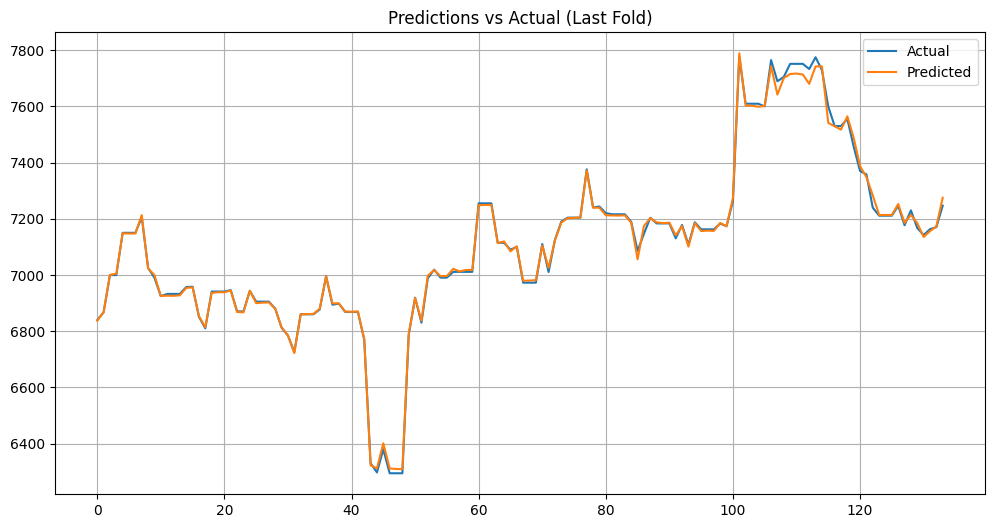

<Figure size 1200x800 with 0 Axes>

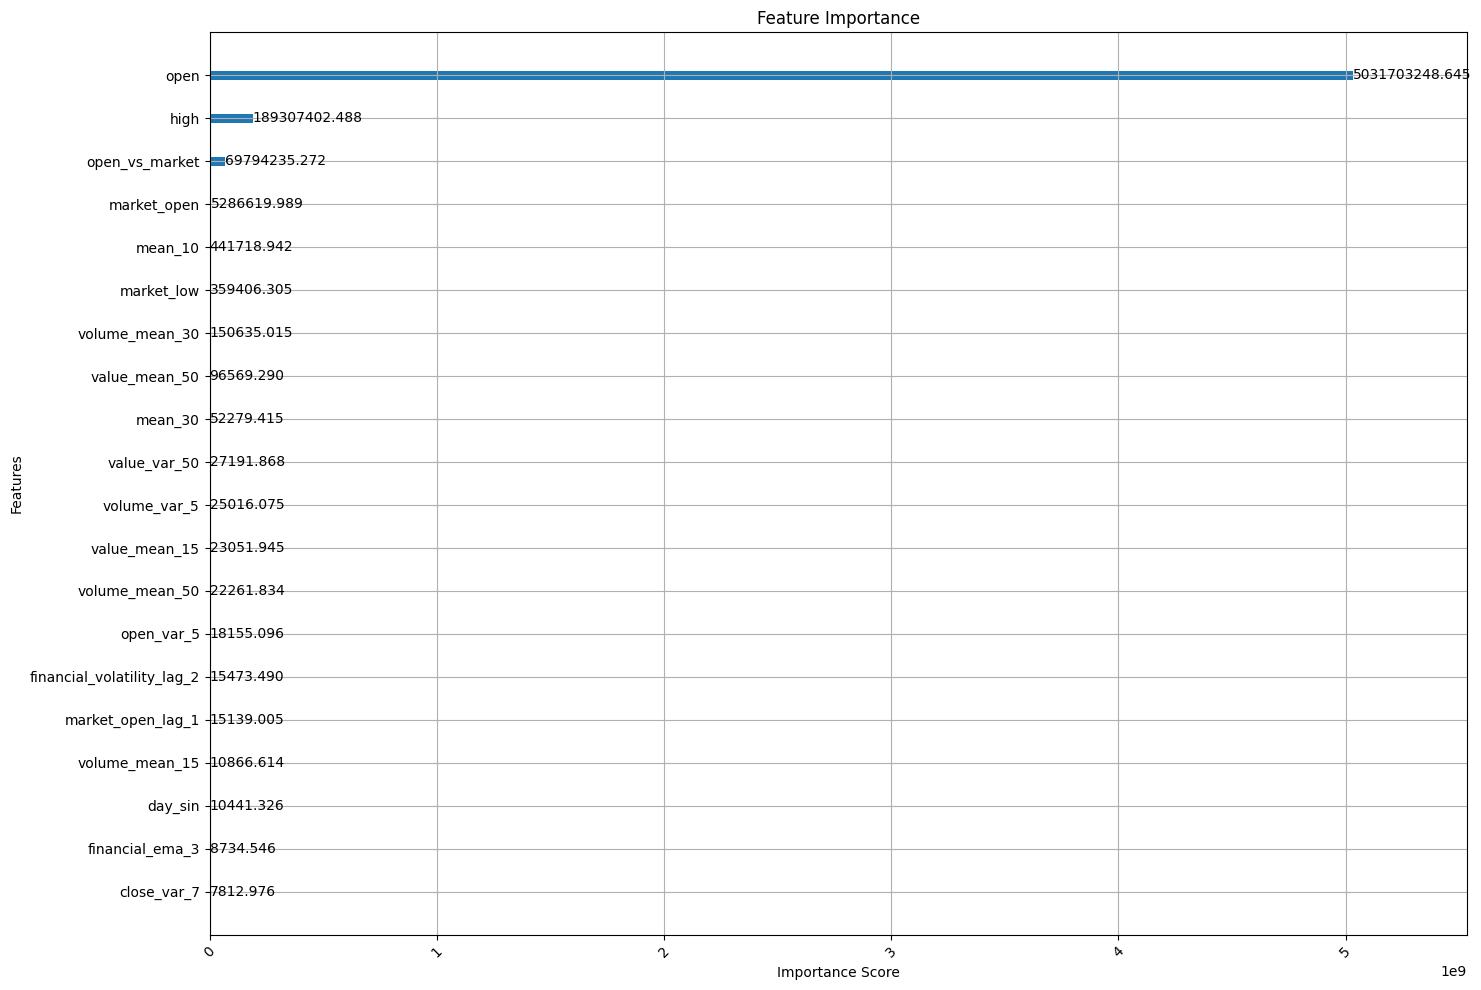

для сравнения тренируем модель без сентимента для компании LKOH


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 875.128
[20]	valid_0's huber: 802.45
[30]	valid_0's huber: 776.714
[40]	valid_0's huber: 769.336
[50]	valid_0's huber: 762.725
[60]	valid_0's huber: 758.774
[70]	valid_0's huber: 756.184
[80]	valid_0's huber: 754.585
[90]	valid_0's huber: 753.21
[100]	valid_0's huber: 752.548
[110]	valid_0's huber: 752.108
[120]	valid_0's huber: 751.745
[130]	valid_0's huber: 751.514
[140]	valid_0's huber: 751.317
[150]	valid_0's huber: 751.138
[160]	valid_0's huber: 751.033
[170]	valid_0's huber: 750.957
[180]	valid_0's huber: 750.912
[190]	valid_0's huber: 750.869
[200]	valid_0's huber: 750.837
[210]	valid_0's huber: 750.813
[220]	valid_0's huber: 750.8
[230]	valid_0's huber: 750.785
[240]	valid_0's huber: 750.779
[250]	valid_0's huber: 750.772
[260]	valid_0's huber: 750.766
[270]	valid_0's huber: 750.762
[280]	valid_0's huber: 750.76
[290]	valid_0's huber

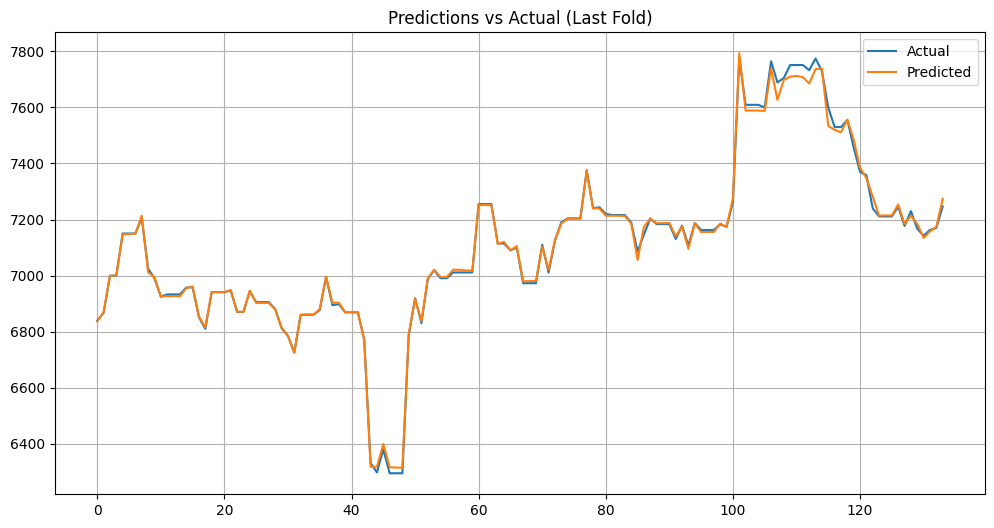

<Figure size 1200x800 with 0 Axes>

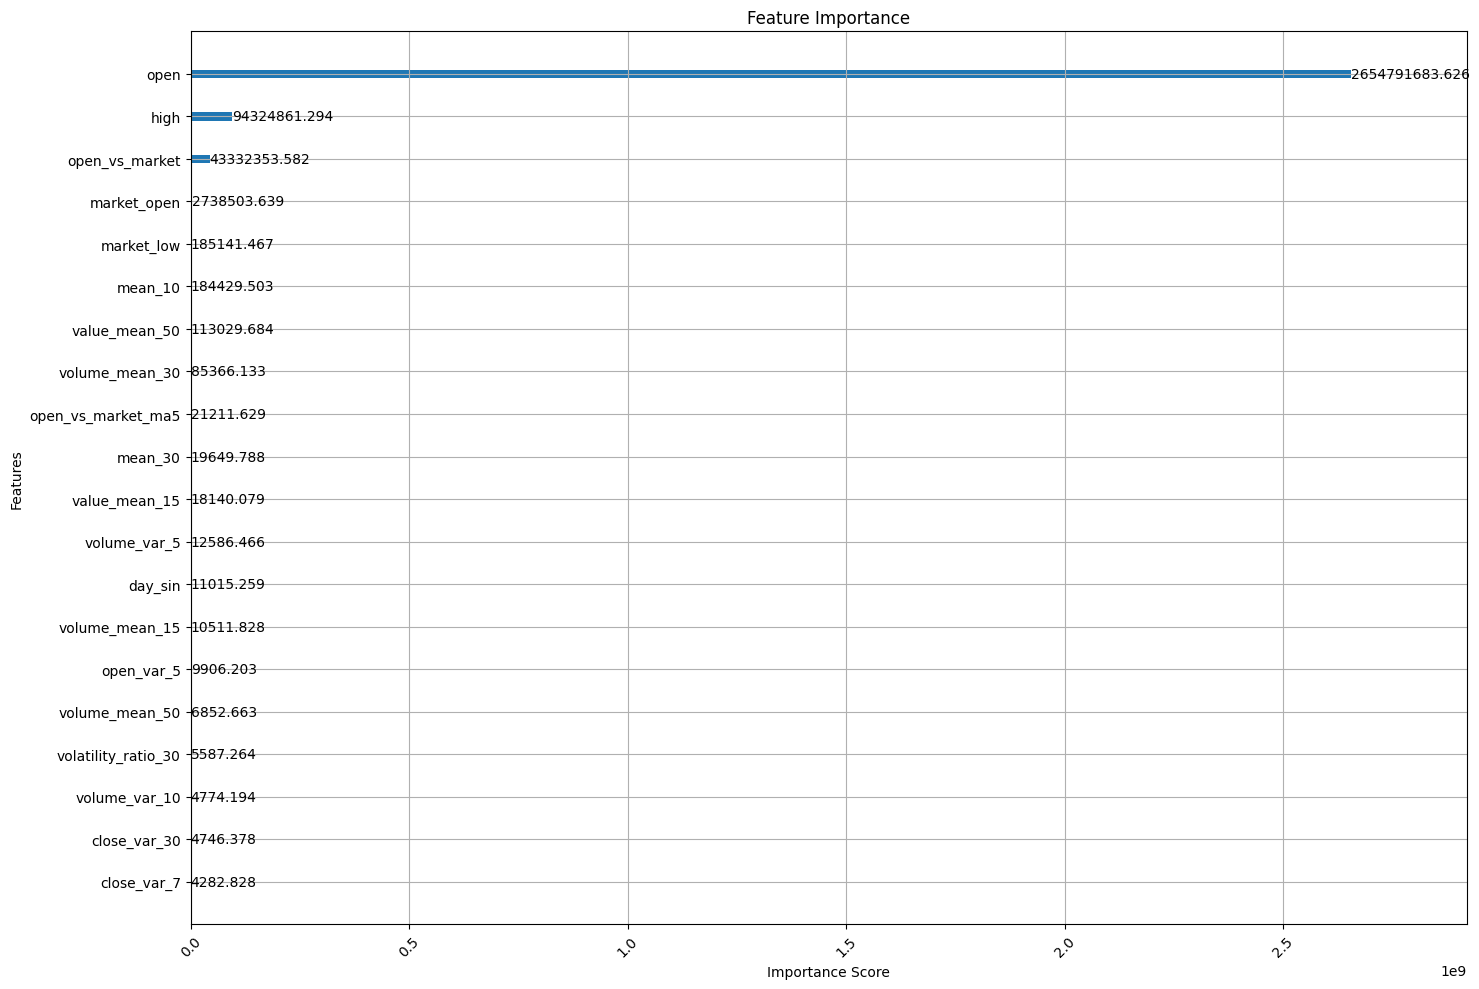

training model for company: VTBR


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_d

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 17.4318
[20]	valid_0's huber: 13.1023
[30]	valid_0's huber: 11.553
[40]	valid_0's huber: 11.067
[50]	valid_0's huber: 10.9362
[60]	valid_0's huber: 10.9053
[70]	valid_0's huber: 10.8917
[80]	valid_0's huber: 10.8855
[90]	valid_0's huber: 10.8841
[100]	valid_0's huber: 10.8832
[110]	valid_0's huber: 10.8817
[120]	valid_0's huber: 10.8821
Early stopping, best iteration is:
[110]	valid_0's huber: 10.8817
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 3.79987
[20]	valid_0's huber: 1.42817
[30]	valid_0's huber: 1.05774
Early stopping, best iteration is:
[29]	valid_0's huber: 1.05307
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 1.61542
[20]	valid_0's huber: 0.358632
[30]	valid_0's huber: 0.0927439
[40]	valid_0's huber: 0.0561272
[50]	valid_0's huber: 0.0564945
Early stopping

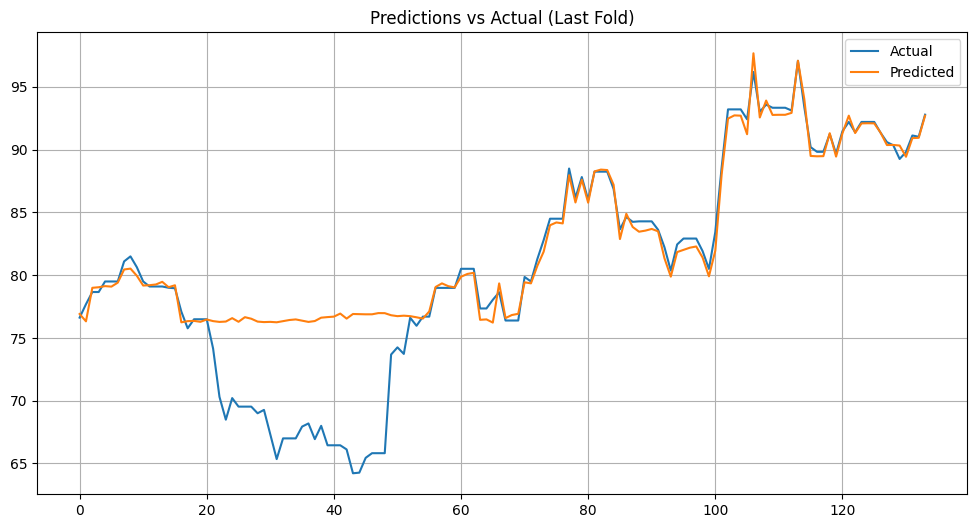

<Figure size 1200x800 with 0 Axes>

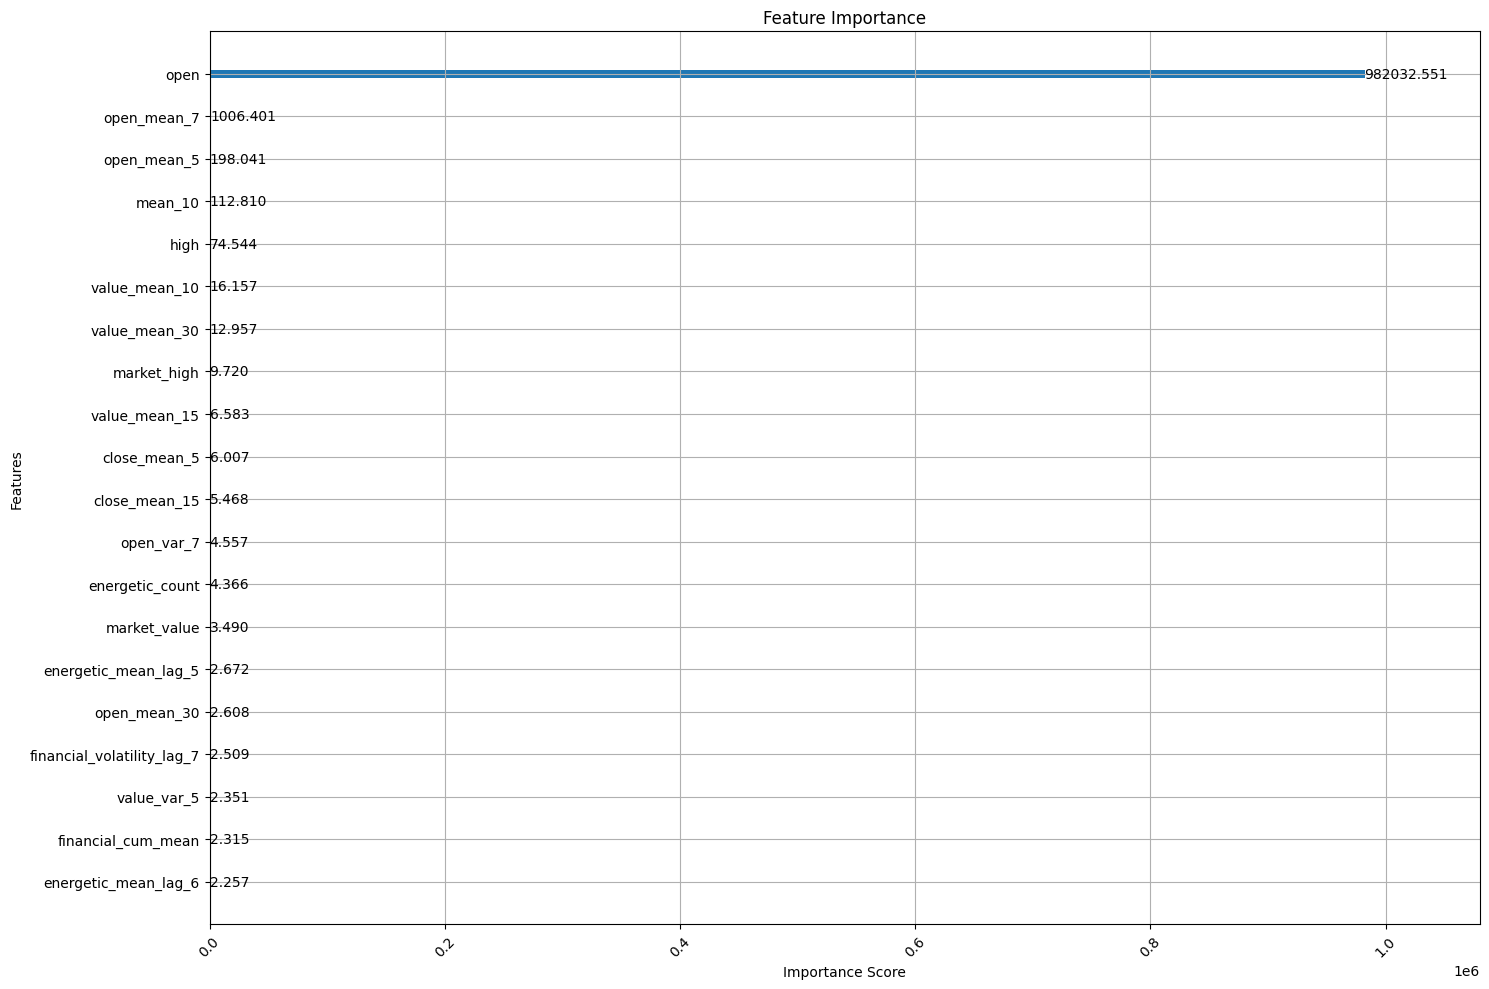

для сравнения тренируем модель без сентимента для компании VTBR


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 17.4318
[20]	valid_0's huber: 13.0264
[30]	valid_0's huber: 11.5383
[40]	valid_0's huber: 11.094
[50]	valid_0's huber: 10.9569
[60]	valid_0's huber: 10.9108
[70]	valid_0's huber: 10.8995
[80]	valid_0's huber: 10.8965
[90]	valid_0's huber: 10.8971
[100]	valid_0's huber: 10.893
[110]	valid_0's huber: 10.8906
Early stopping, best iteration is:
[106]	valid_0's huber: 10.8899
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 3.79987
[20]	valid_0's huber: 1.42817
[30]	valid_0's huber: 1.06436
[40]	valid_0's huber: 1.135
Early stopping, best iteration is:
[30]	valid_0's huber: 1.06436
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 1.61542
[20]	valid_0's huber: 0.358632
[30]	valid_0's huber: 0.0874249
[40]	valid_0's huber: 0.0629954
Early stopping, best iteration is:
[39]	valid_0's

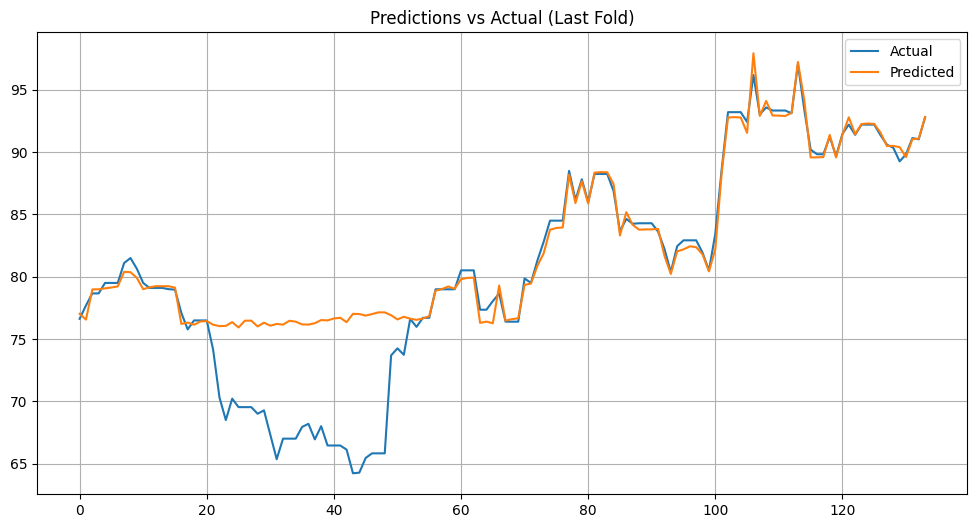

<Figure size 1200x800 with 0 Axes>

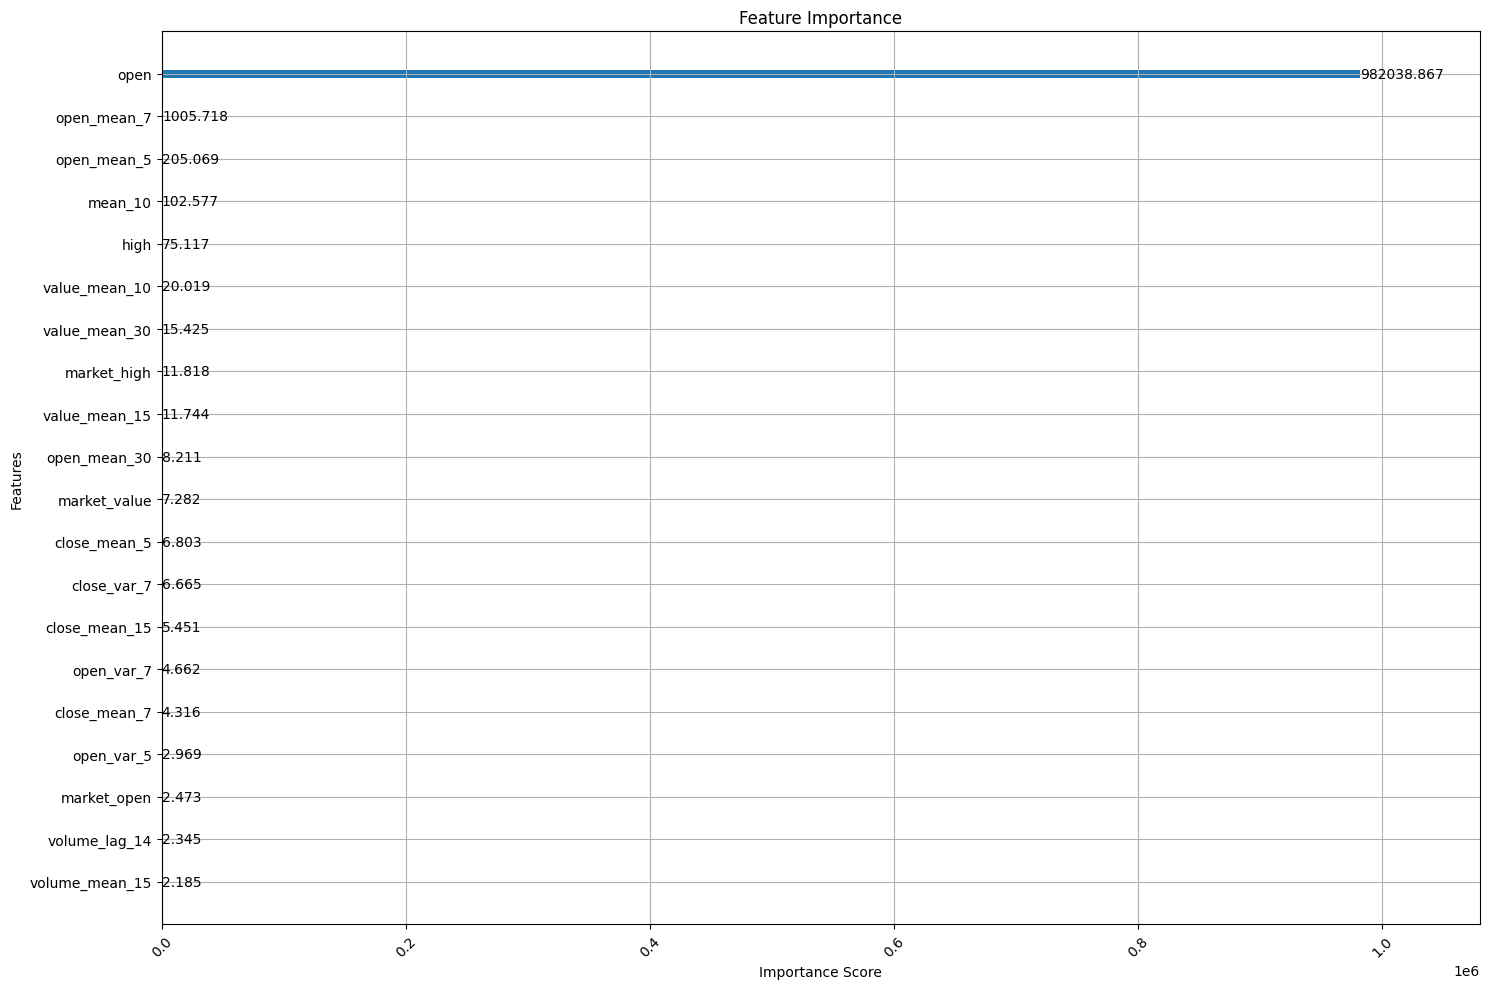

training model for company: SBER


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_d

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 25.3525
[20]	valid_0's huber: 15.0675
[30]	valid_0's huber: 11.4299
[40]	valid_0's huber: 10.1765
[50]	valid_0's huber: 9.74788
[60]	valid_0's huber: 9.56779
[70]	valid_0's huber: 9.50787
[80]	valid_0's huber: 9.47671
[90]	valid_0's huber: 9.46402
[100]	valid_0's huber: 9.45503
[110]	valid_0's huber: 9.44628
[120]	valid_0's huber: 9.44077
[130]	valid_0's huber: 9.43927
[140]	valid_0's huber: 9.43484
[150]	valid_0's huber: 9.43067
[160]	valid_0's huber: 9.42531
[170]	valid_0's huber: 9.42478
[180]	valid_0's huber: 9.42223
[190]	valid_0's huber: 9.4202
[200]	valid_0's huber: 9.41712
[210]	valid_0's huber: 9.41603
[220]	valid_0's huber: 9.41358
[230]	valid_0's huber: 9.41272
[240]	valid_0's huber: 9.41185
[250]	valid_0's huber: 9.41063
[260]	valid_0's huber: 9.40986
[270]	valid_0's huber: 9.40919
[280]	valid_0's huber: 9.40865
[290]	valid_0's h

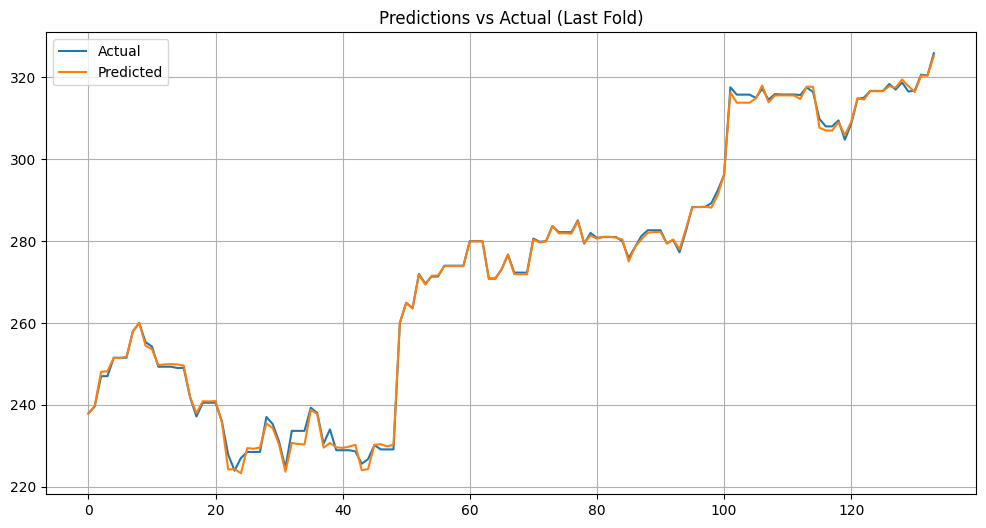

<Figure size 1200x800 with 0 Axes>

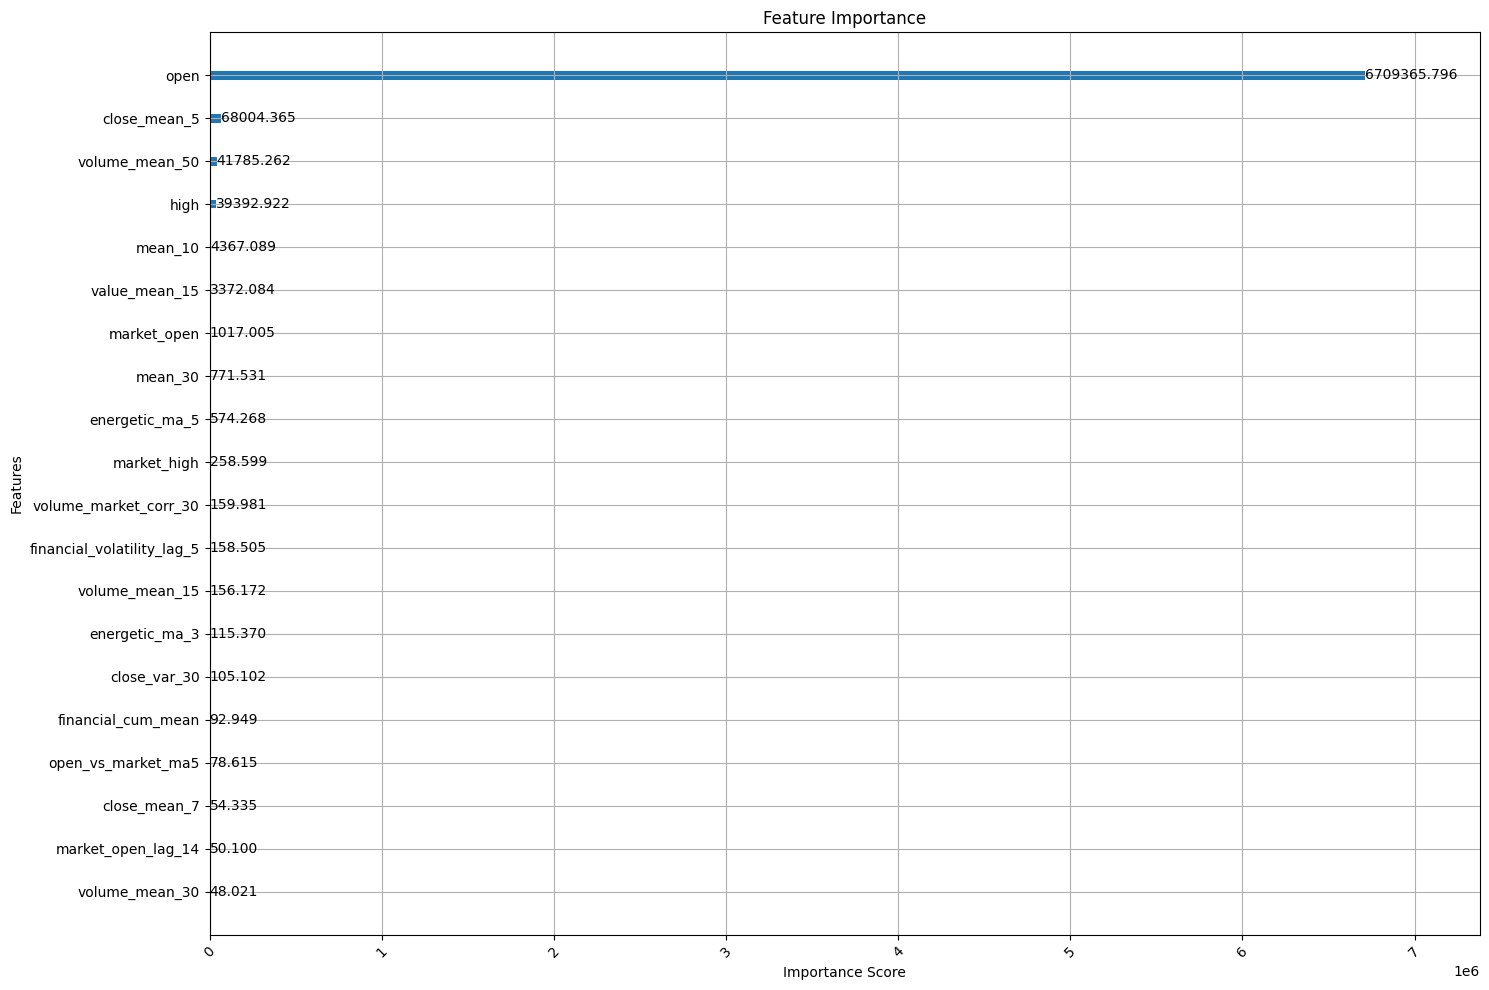

для сравнения тренируем модель без сентимента для компании SBER


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 25.3492
[20]	valid_0's huber: 15.0578
[30]	valid_0's huber: 11.4428
[40]	valid_0's huber: 10.1619
[50]	valid_0's huber: 9.71531
[60]	valid_0's huber: 9.56601
[70]	valid_0's huber: 9.48811
[80]	valid_0's huber: 9.45652
[90]	valid_0's huber: 9.44102
[100]	valid_0's huber: 9.42789
[110]	valid_0's huber: 9.42043
[120]	valid_0's huber: 9.41547
[130]	valid_0's huber: 9.4081
[140]	valid_0's huber: 9.40222
[150]	valid_0's huber: 9.39563
[160]	valid_0's huber: 9.39107
[170]	valid_0's huber: 9.38598
[180]	valid_0's huber: 9.38211
[190]	valid_0's huber: 9.37732
[200]	valid_0's huber: 9.37521
[210]	valid_0's huber: 9.37206
[220]	valid_0's huber: 9.36876
[230]	valid_0's huber: 9.36697
[240]	valid_0's huber: 9.36463
[250]	valid_0's huber: 9.36335
[260]	valid_0's huber: 9.3619
[270]	valid_0's huber: 9.36041
[280]	valid_0's huber: 9.35963
[290]	valid_0's hu

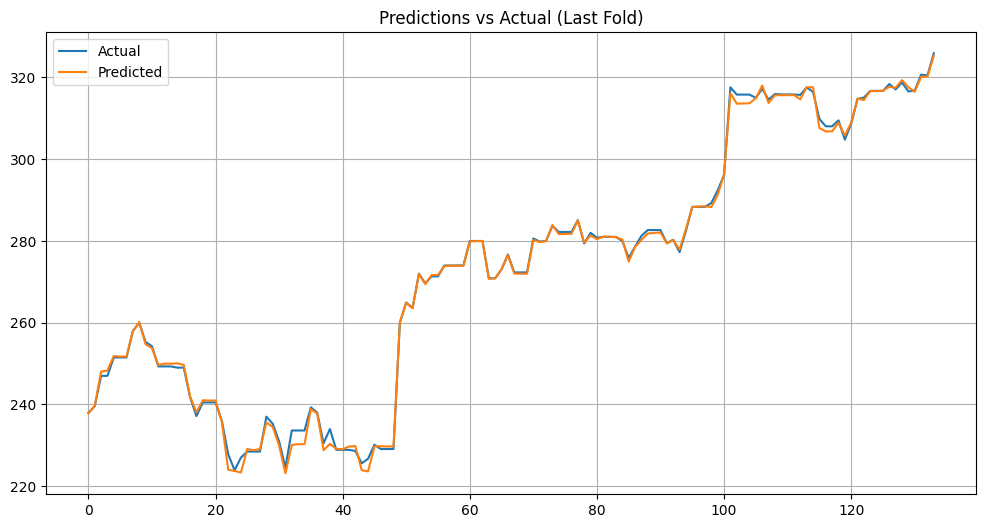

<Figure size 1200x800 with 0 Axes>

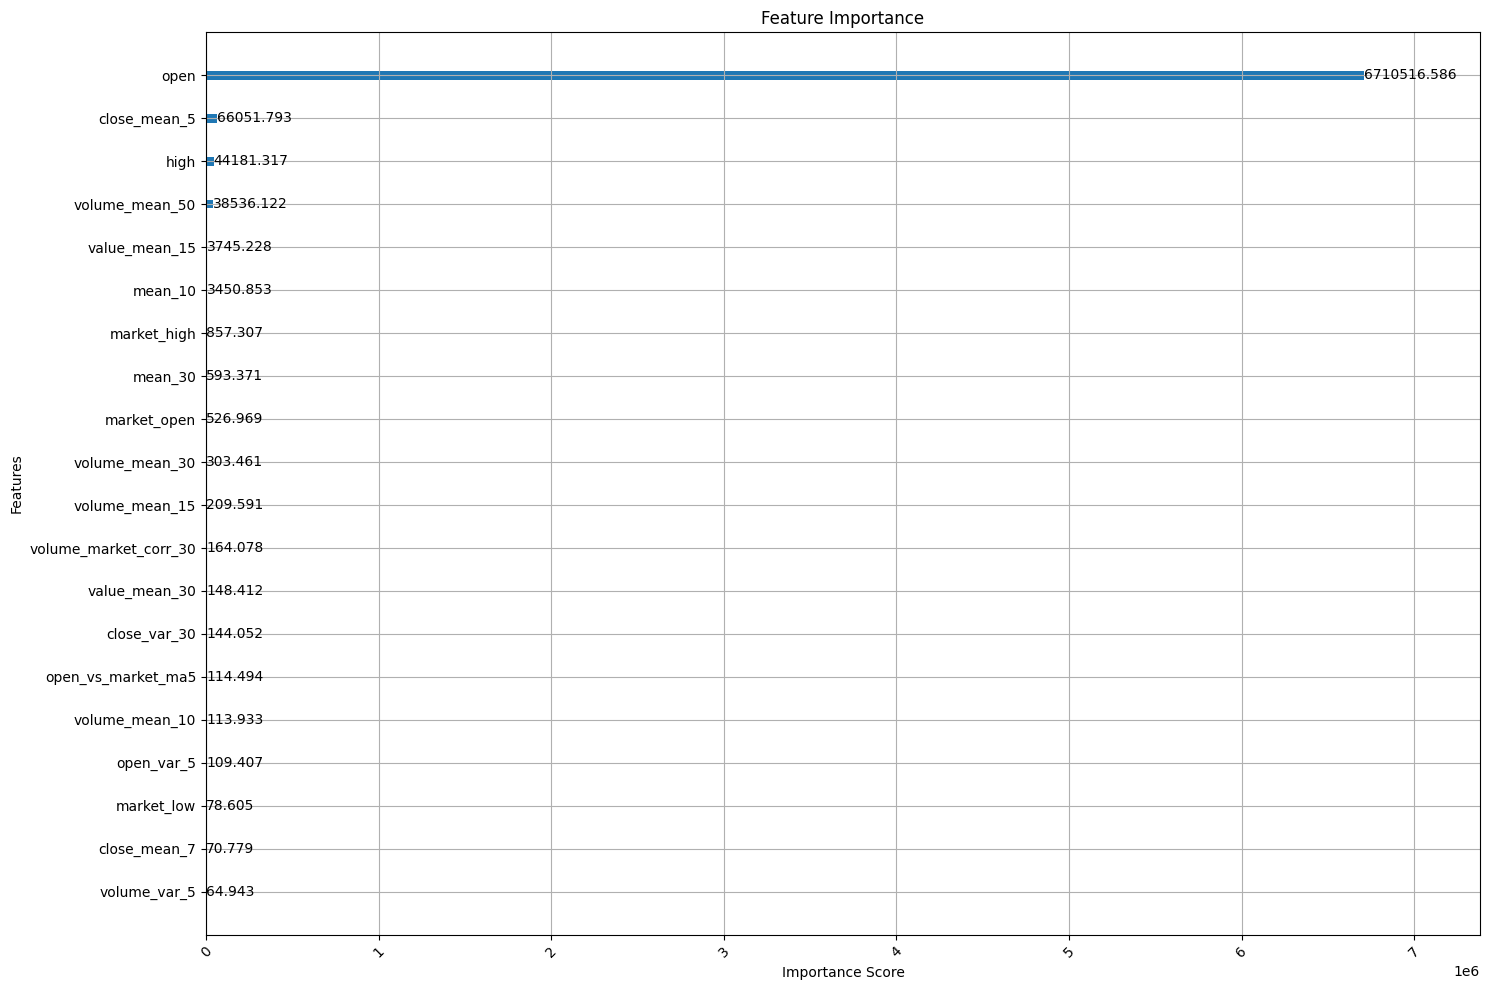

training model for company: ROSN


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_d

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 98.8885
[20]	valid_0's huber: 91.3552
[30]	valid_0's huber: 88.2869
[40]	valid_0's huber: 87.3531
[50]	valid_0's huber: 86.4687
[60]	valid_0's huber: 86.1229
[70]	valid_0's huber: 85.9436
[80]	valid_0's huber: 85.8175
[90]	valid_0's huber: 85.6808
[100]	valid_0's huber: 85.597
[110]	valid_0's huber: 85.5551
[120]	valid_0's huber: 85.4849
[130]	valid_0's huber: 85.4498
[140]	valid_0's huber: 85.4015
[150]	valid_0's huber: 85.3723
[160]	valid_0's huber: 85.3363
[170]	valid_0's huber: 85.3061
[180]	valid_0's huber: 85.2871
[190]	valid_0's huber: 85.2716
[200]	valid_0's huber: 85.2527
[210]	valid_0's huber: 85.2396
[220]	valid_0's huber: 85.23
[230]	valid_0's huber: 85.2176
[240]	valid_0's huber: 85.2111
[250]	valid_0's huber: 85.2002
[260]	valid_0's huber: 85.1918
[270]	valid_0's huber: 85.1874
[280]	valid_0's huber: 85.183
[290]	valid_0's hube

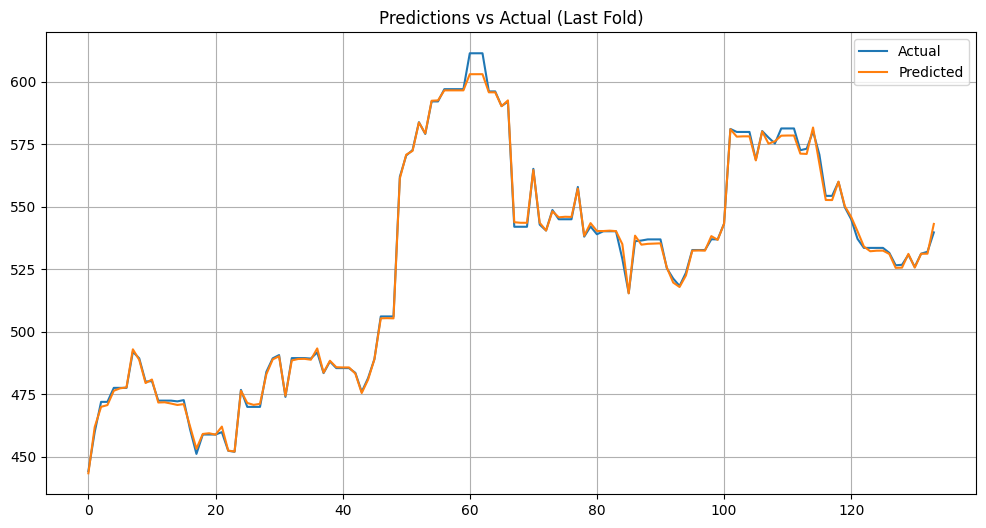

<Figure size 1200x800 with 0 Axes>

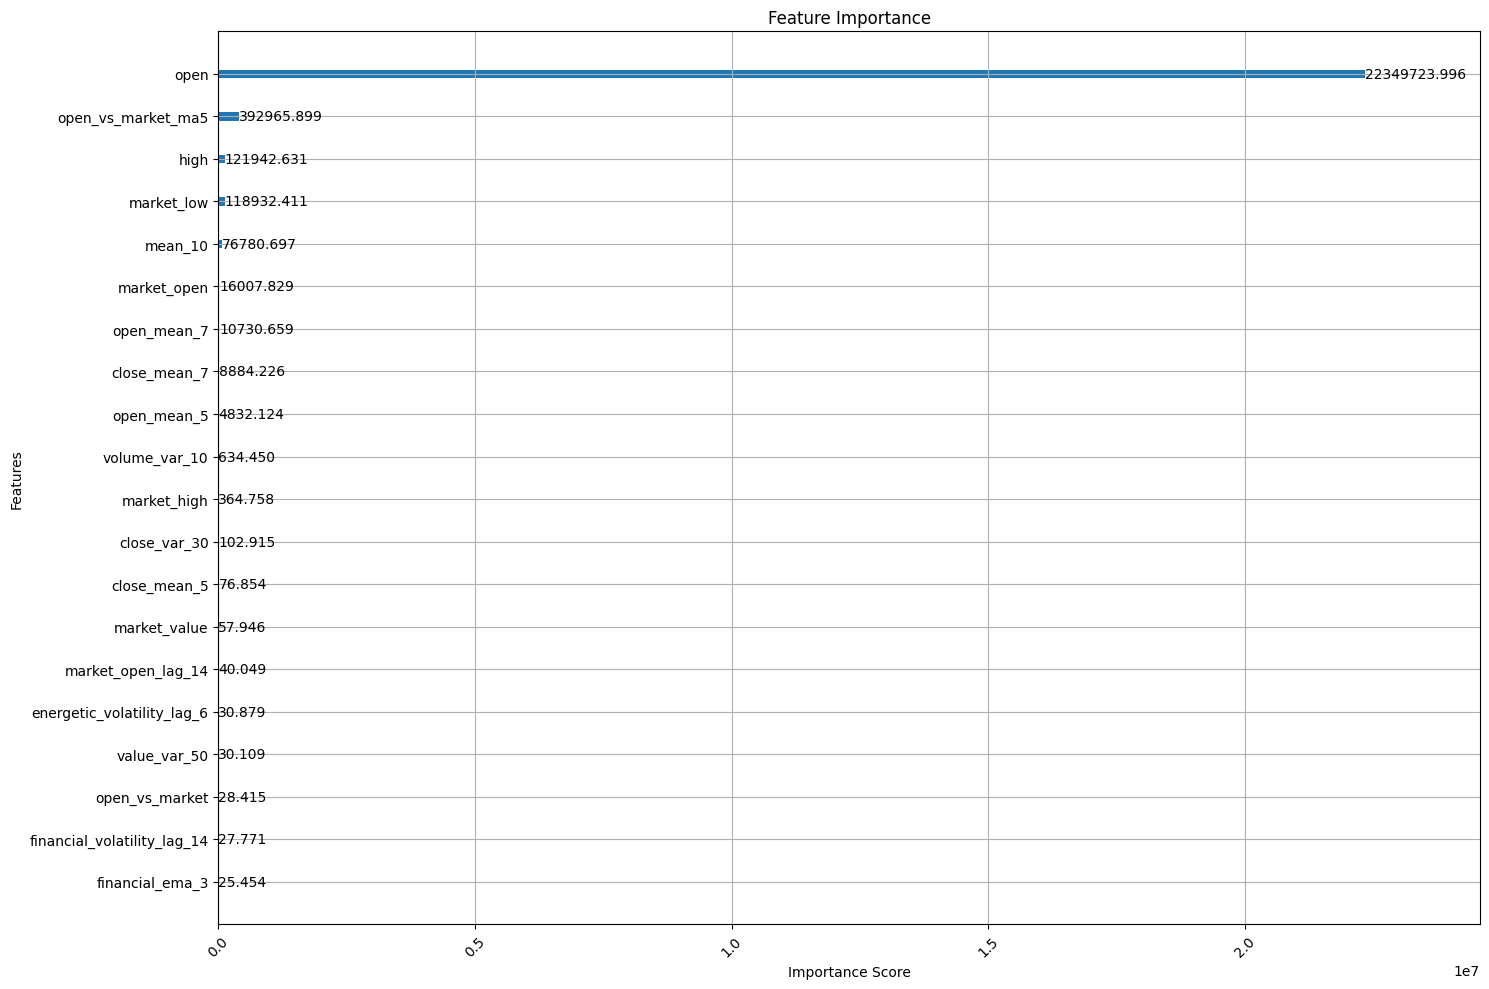

для сравнения тренируем модель без сентимента для компании ROSN


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 98.6317
[20]	valid_0's huber: 91.0957
[30]	valid_0's huber: 88.109
[40]	valid_0's huber: 86.6586
[50]	valid_0's huber: 85.8106
[60]	valid_0's huber: 85.3728
[70]	valid_0's huber: 85.1561
[80]	valid_0's huber: 84.9605
[90]	valid_0's huber: 84.7706
[100]	valid_0's huber: 84.6456
[110]	valid_0's huber: 84.5117
[120]	valid_0's huber: 84.4282
[130]	valid_0's huber: 84.3366
[140]	valid_0's huber: 84.2788
[150]	valid_0's huber: 84.2486
[160]	valid_0's huber: 84.1948
[170]	valid_0's huber: 84.1641
[180]	valid_0's huber: 84.1478
[190]	valid_0's huber: 84.1189
[200]	valid_0's huber: 84.0856
[210]	valid_0's huber: 84.0715
[220]	valid_0's huber: 84.0516
[230]	valid_0's huber: 84.031
[240]	valid_0's huber: 84.0216
[250]	valid_0's huber: 84.014
[260]	valid_0's huber: 84.0045
[270]	valid_0's huber: 83.9965
[280]	valid_0's huber: 83.9868
[290]	valid_0's hub

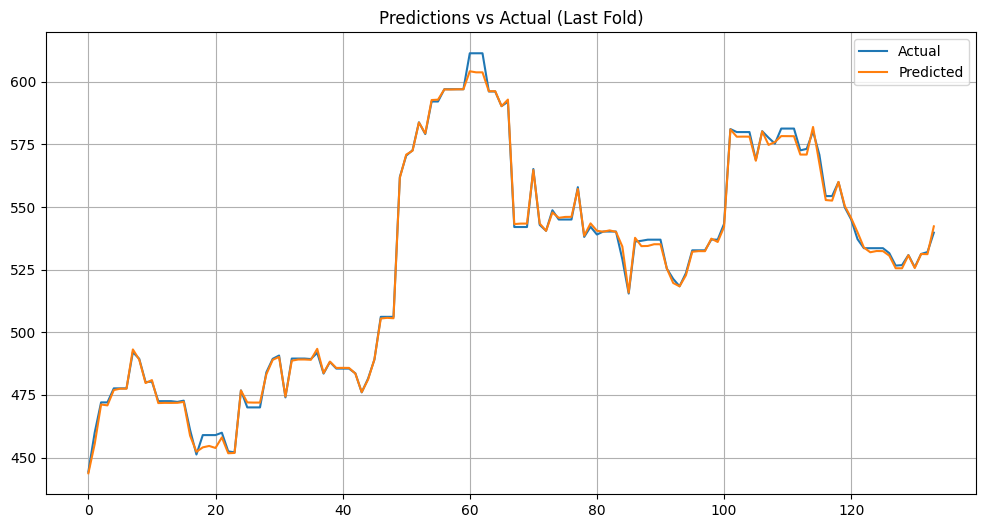

<Figure size 1200x800 with 0 Axes>

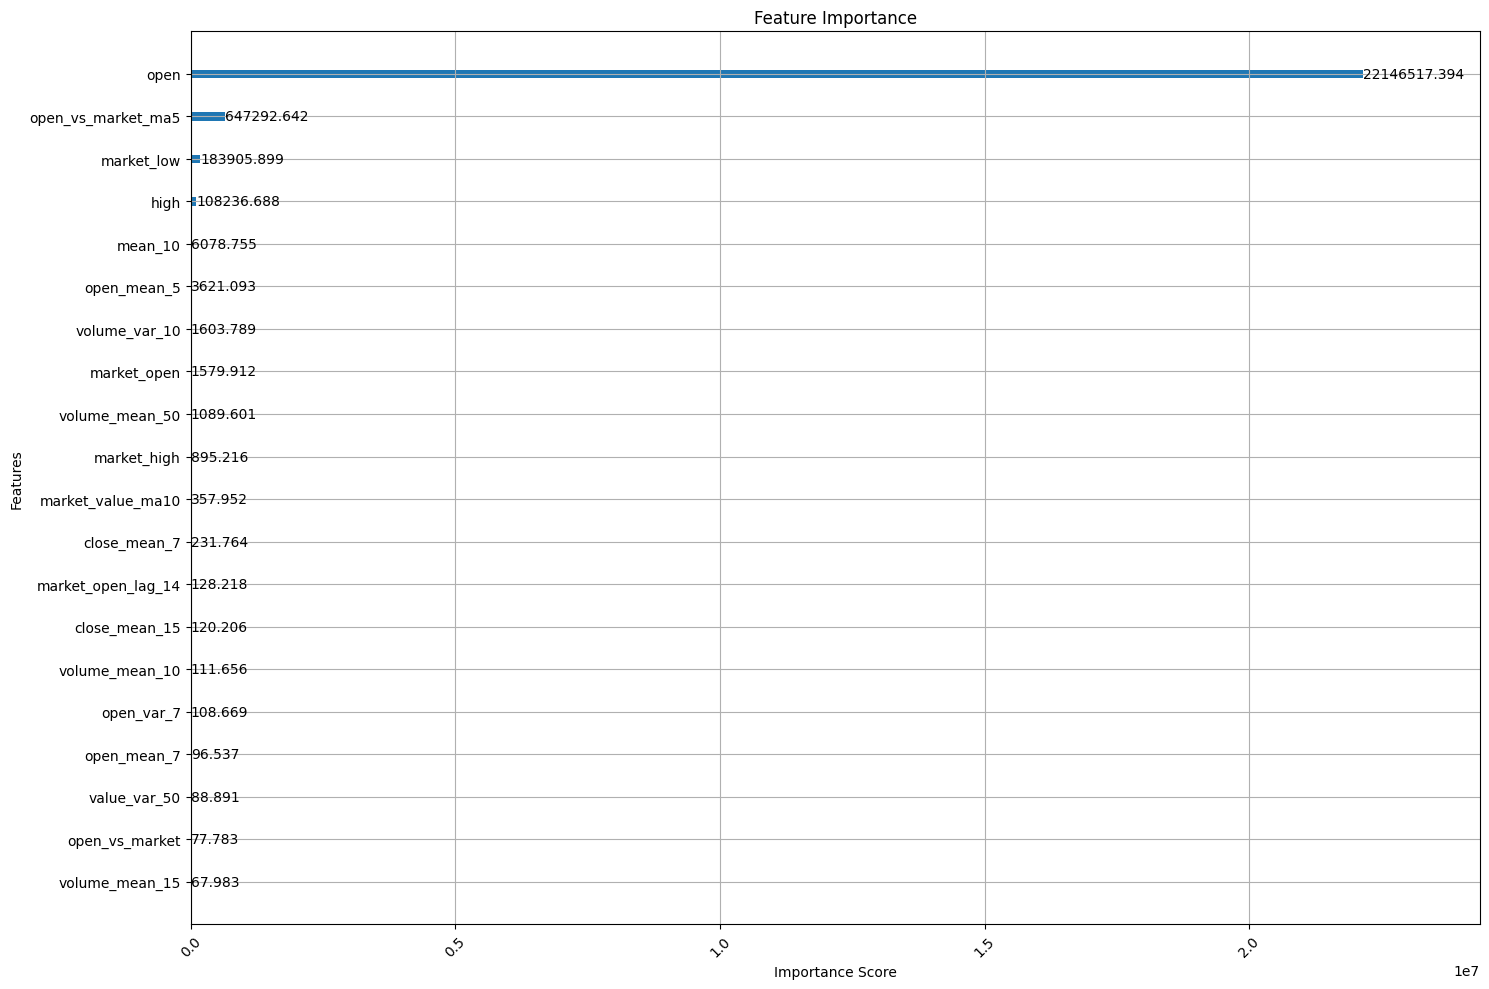

training model for company: GAZP


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_d

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 4.15745
[20]	valid_0's huber: 3.89781
[30]	valid_0's huber: 3.66064
[40]	valid_0's huber: 3.36597
[50]	valid_0's huber: 3.10882
[60]	valid_0's huber: 2.93647
[70]	valid_0's huber: 2.79193
[80]	valid_0's huber: 2.64231
[90]	valid_0's huber: 2.48718
[100]	valid_0's huber: 2.34565
[110]	valid_0's huber: 2.2071
[120]	valid_0's huber: 2.07462
[130]	valid_0's huber: 1.96571
[140]	valid_0's huber: 1.86302
[150]	valid_0's huber: 1.76661
[160]	valid_0's huber: 1.67778
[170]	valid_0's huber: 1.57268
[180]	valid_0's huber: 1.51287
[190]	valid_0's huber: 1.44321
[200]	valid_0's huber: 1.37962
[210]	valid_0's huber: 1.32368
[220]	valid_0's huber: 1.28186
[230]	valid_0's huber: 1.26113
[240]	valid_0's huber: 1.2509
[250]	valid_0's huber: 1.24898
[260]	valid_0's huber: 1.25232
Early stopping, best iteration is:
[251]	valid_0's huber: 1.24779
Training until

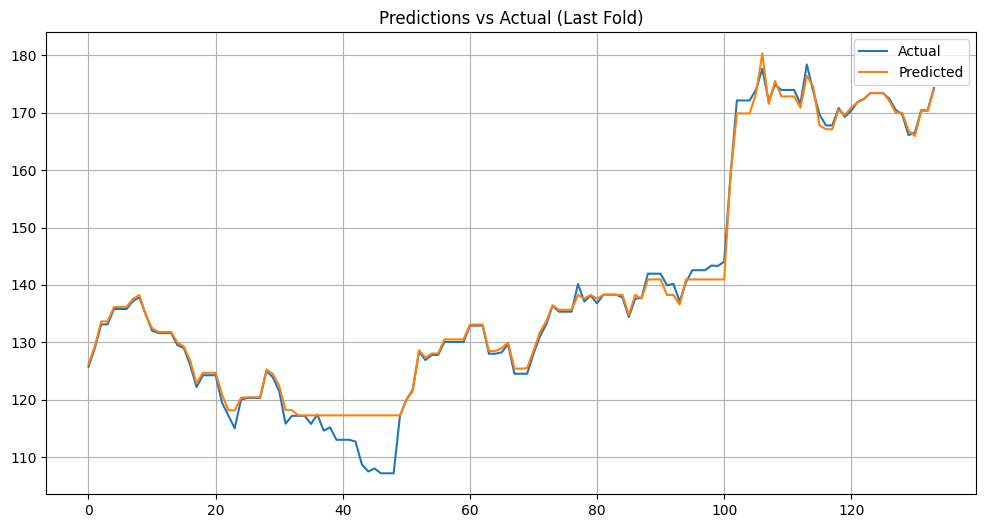

<Figure size 1200x800 with 0 Axes>

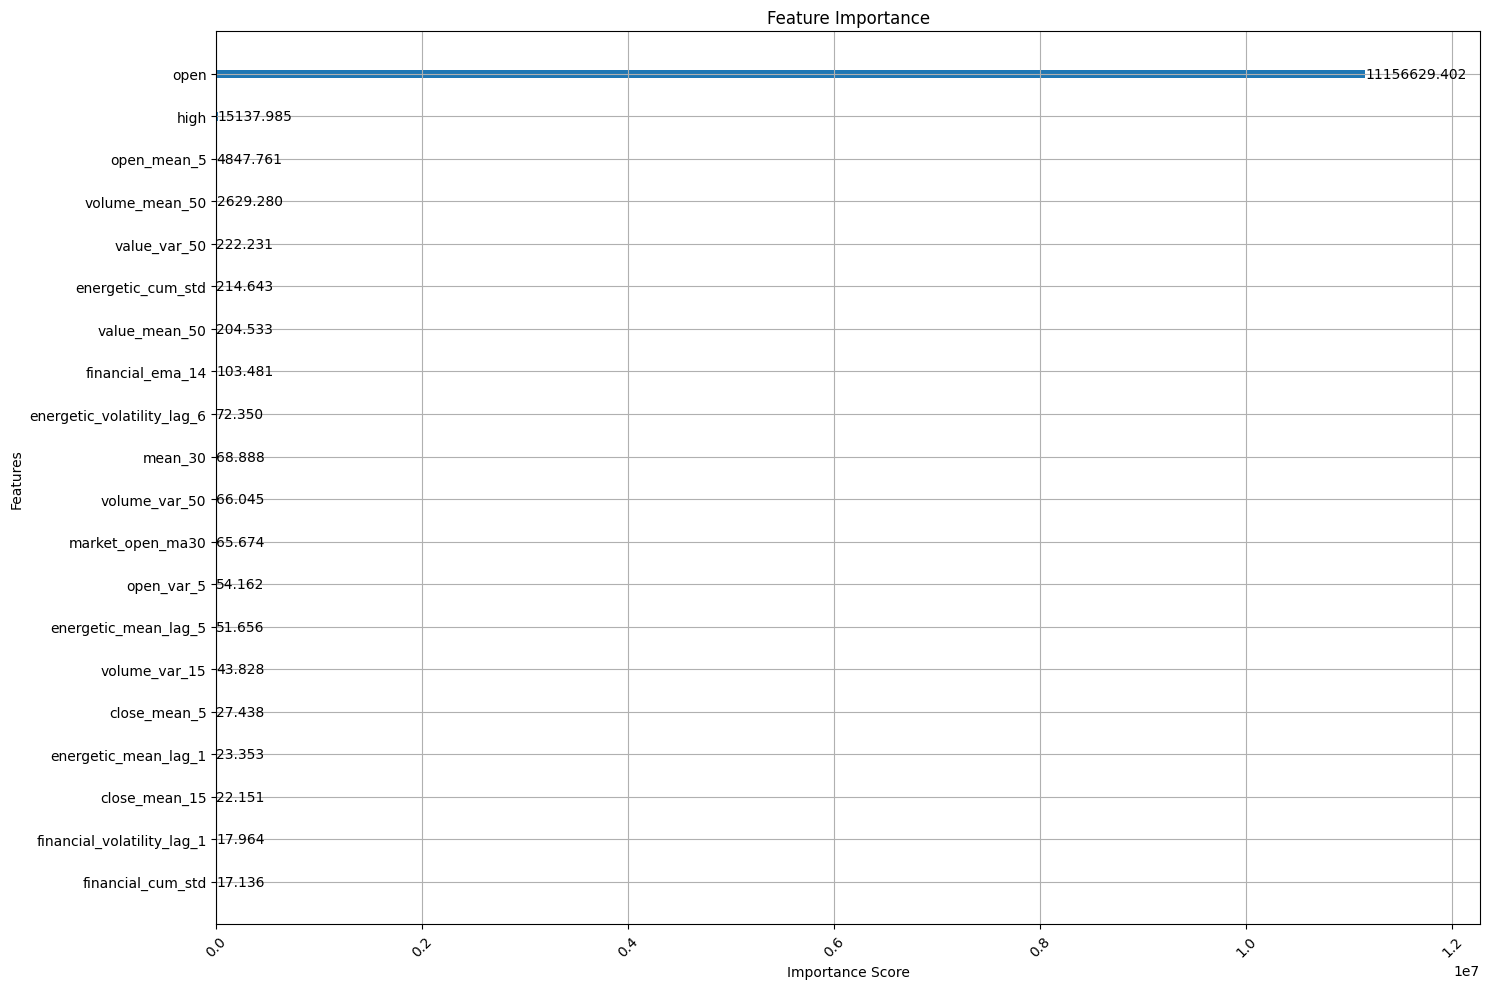

для сравнения тренируем модель без сентимента для компании GAZP


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 4.15745
[20]	valid_0's huber: 3.89781
[30]	valid_0's huber: 3.66064
[40]	valid_0's huber: 3.36597
[50]	valid_0's huber: 3.10882
[60]	valid_0's huber: 2.93647
[70]	valid_0's huber: 2.79193
[80]	valid_0's huber: 2.63785
[90]	valid_0's huber: 2.47891
[100]	valid_0's huber: 2.31557
[110]	valid_0's huber: 2.15936
[120]	valid_0's huber: 2.03788
[130]	valid_0's huber: 1.91266
[140]	valid_0's huber: 1.79506
[150]	valid_0's huber: 1.69164
[160]	valid_0's huber: 1.60264
[170]	valid_0's huber: 1.53584
[180]	valid_0's huber: 1.45588
[190]	valid_0's huber: 1.38206
[200]	valid_0's huber: 1.3204
[210]	valid_0's huber: 1.25951
[220]	valid_0's huber: 1.21588
[230]	valid_0's huber: 1.17874
[240]	valid_0's huber: 1.16849
Early stopping, best iteration is:
[238]	valid_0's huber: 1.16701
Training until validation scores don't improve for 10 rounds
[10]	valid_0's

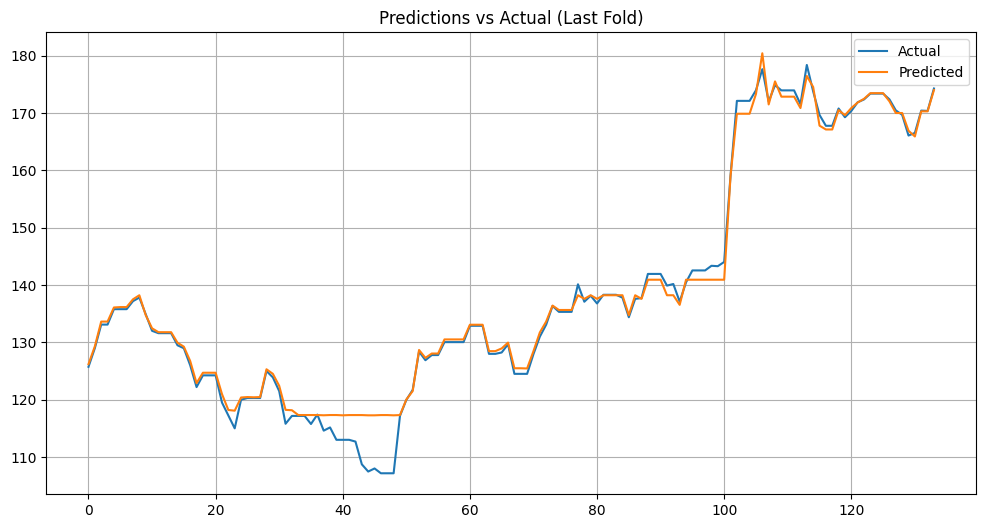

<Figure size 1200x800 with 0 Axes>

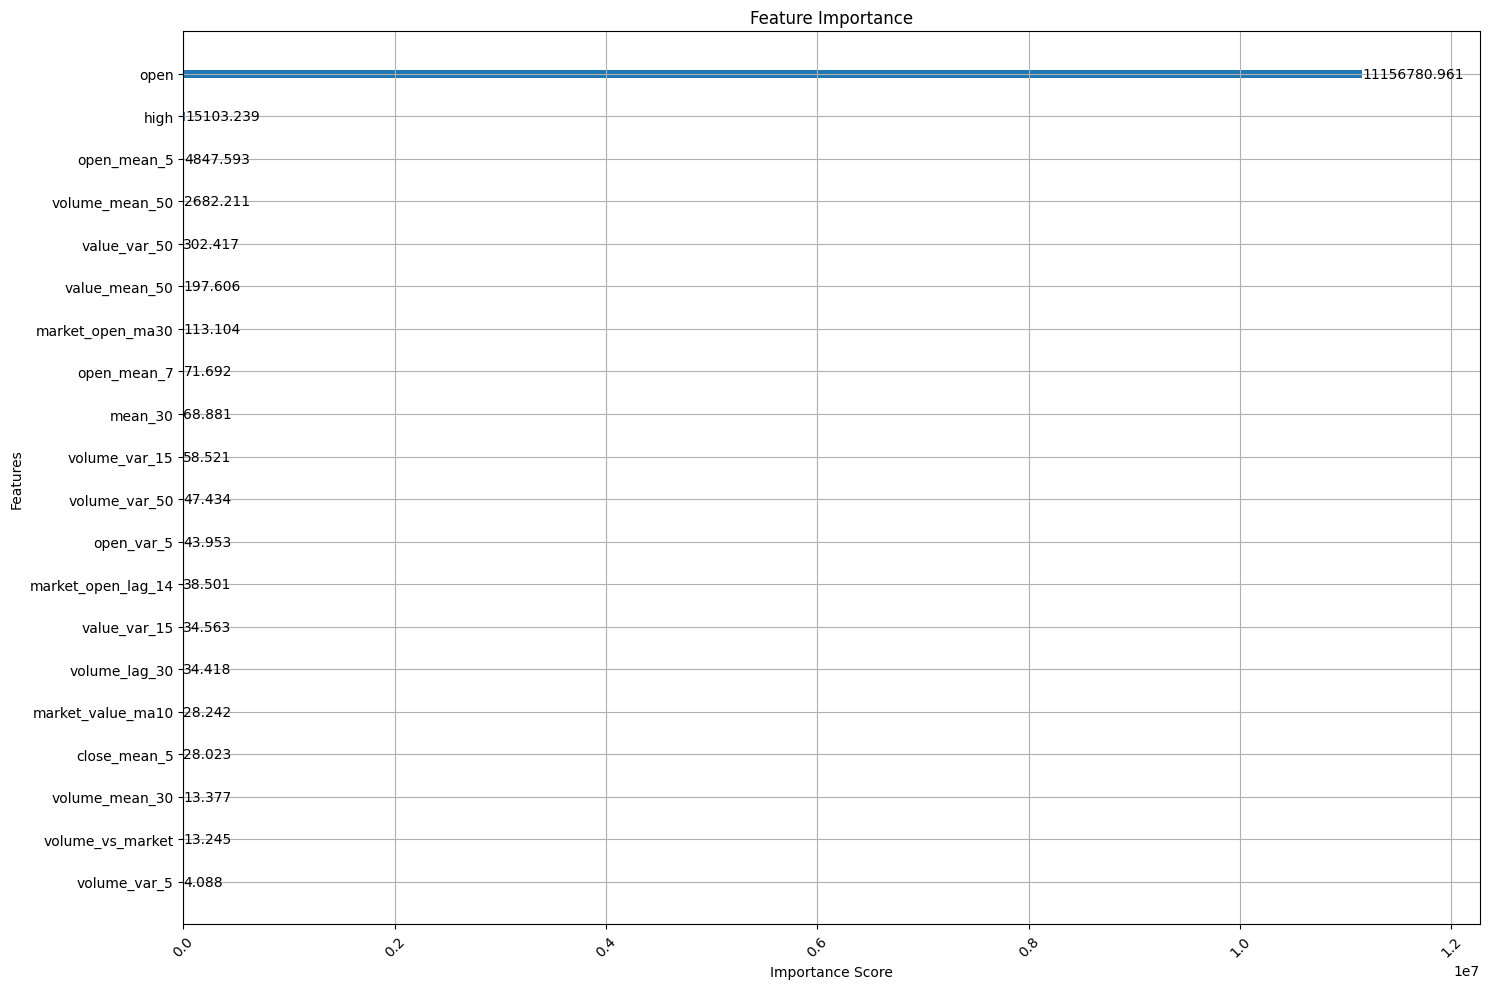

training model for company: T


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\1295345289.py:64: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df[f'{prefix}_relative_momentum_1'] = test_d

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 612.239
[20]	valid_0's huber: 576.168
[30]	valid_0's huber: 563.494
[40]	valid_0's huber: 555.468
[50]	valid_0's huber: 551.588
[60]	valid_0's huber: 548.022
[70]	valid_0's huber: 546.231
[80]	valid_0's huber: 543.051
[90]	valid_0's huber: 541.164
[100]	valid_0's huber: 539.207
[110]	valid_0's huber: 538.076
[120]	valid_0's huber: 536.342
[130]	valid_0's huber: 535.04
[140]	valid_0's huber: 534.05
[150]	valid_0's huber: 532.967
[160]	valid_0's huber: 532.028
[170]	valid_0's huber: 531.463
[180]	valid_0's huber: 530.553
[190]	valid_0's huber: 530.075
[200]	valid_0's huber: 529.772
[210]	valid_0's huber: 529.337
[220]	valid_0's huber: 528.895
[230]	valid_0's huber: 528.704
[240]	valid_0's huber: 528.407
[250]	valid_0's huber: 528.061
[260]	valid_0's huber: 527.888
[270]	valid_0's huber: 527.701
[280]	valid_0's huber: 527.57
[290]	valid_0's hub

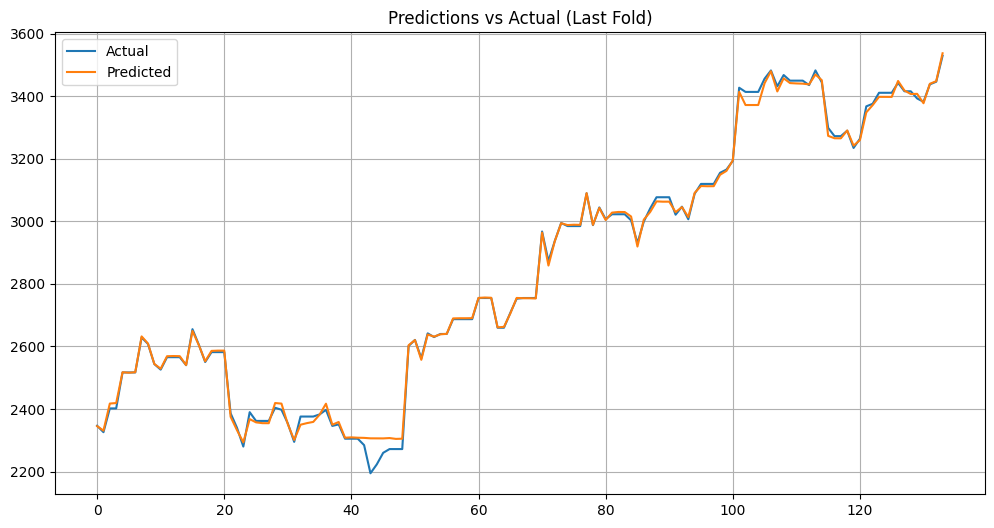

<Figure size 1200x800 with 0 Axes>

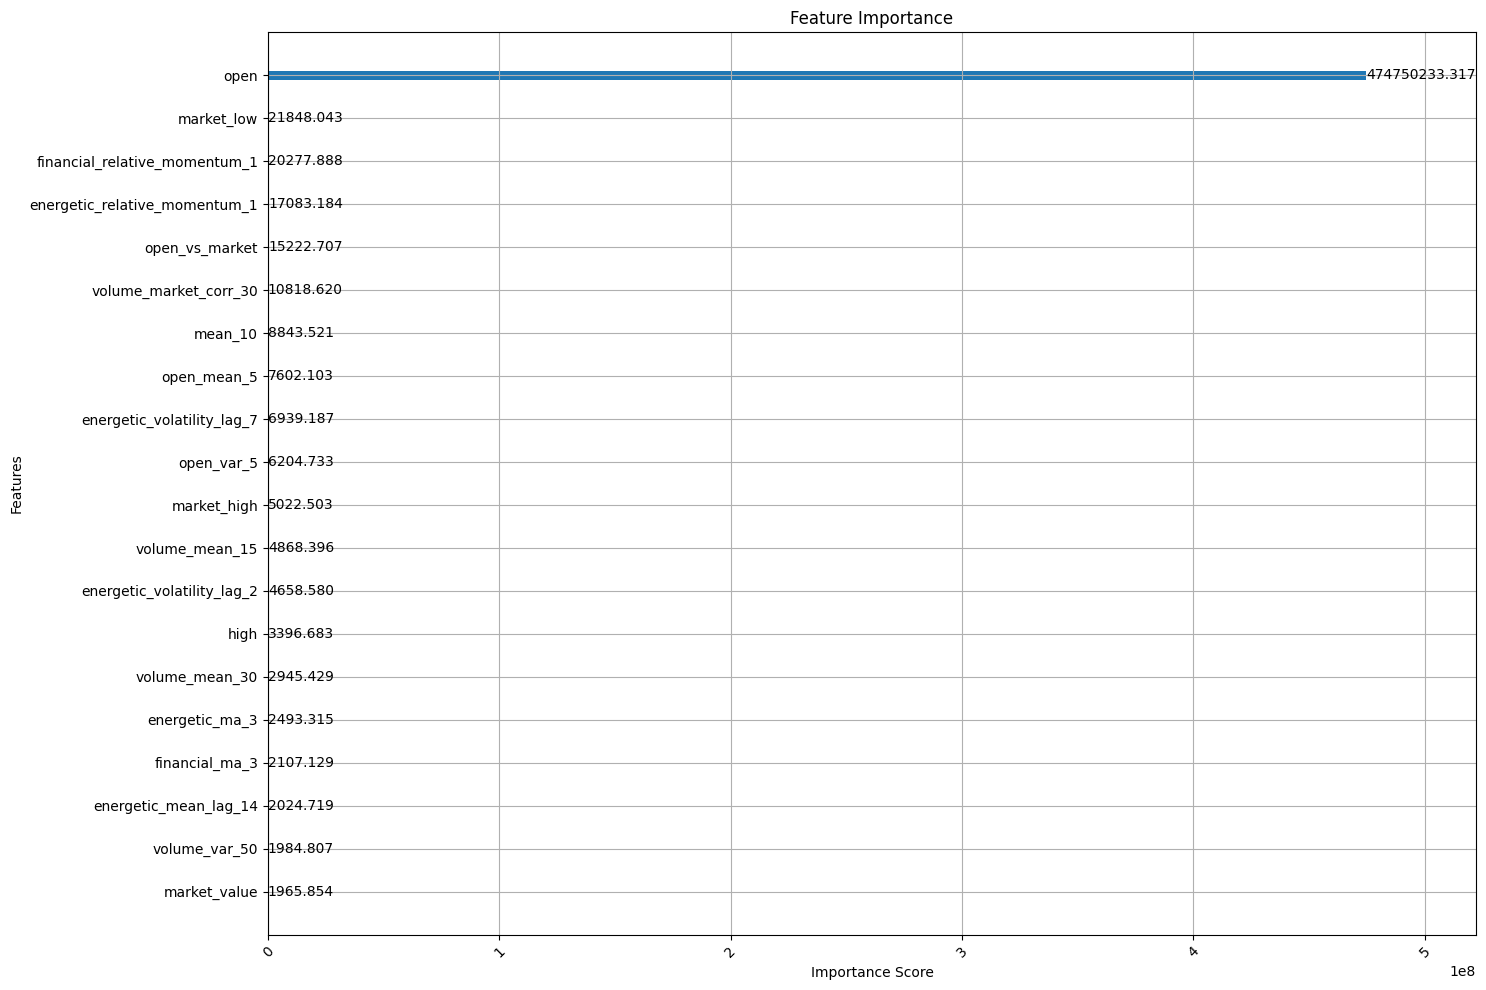

для сравнения тренируем модель без сентимента для компании T


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_company_group[col] = df_company_group[col].fillna(method='ffill')  # Перенос последнего значения
C:\Users\Ivan\AppData\Local\Temp\ipykernel_12584\385785670.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_company_group.fillna(0, inplace=True)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Training until validation scores don't improve for 10 rounds
[10]	valid_0's huber: 613.056
[20]	valid_0's huber: 575.689
[30]	valid_0's huber: 560.049
[40]	valid_0's huber: 548.797
[50]	valid_0's huber: 541.966
[60]	valid_0's huber: 537.979
[70]	valid_0's huber: 534.008
[80]	valid_0's huber: 530.483
[90]	valid_0's huber: 526.941
[100]	valid_0's huber: 523.927
[110]	valid_0's huber: 522.211
[120]	valid_0's huber: 520.258
[130]	valid_0's huber: 518.636
[140]	valid_0's huber: 517.202
[150]	valid_0's huber: 515.986
[160]	valid_0's huber: 514.894
[170]	valid_0's huber: 513.992
[180]	valid_0's huber: 513.025
[190]	valid_0's huber: 512.41
[200]	valid_0's huber: 511.701
[210]	valid_0's huber: 511.318
[220]	valid_0's huber: 510.831
[230]	valid_0's huber: 510.425
[240]	valid_0's huber: 510.063
[250]	valid_0's huber: 509.76
[260]	valid_0's huber: 509.485
[270]	valid_0's huber: 509.219
[280]	valid_0's huber: 509.021
[290]	valid_0's hu

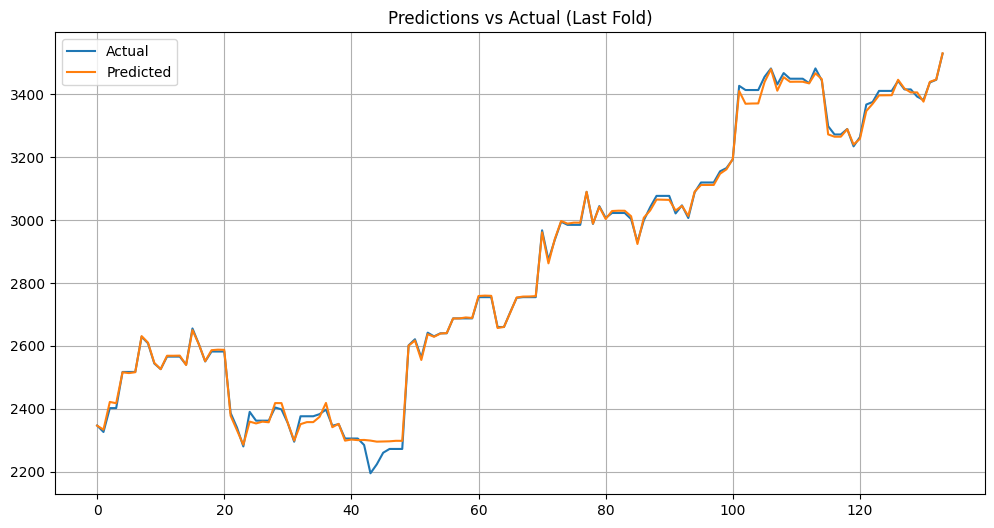

<Figure size 1200x800 with 0 Axes>

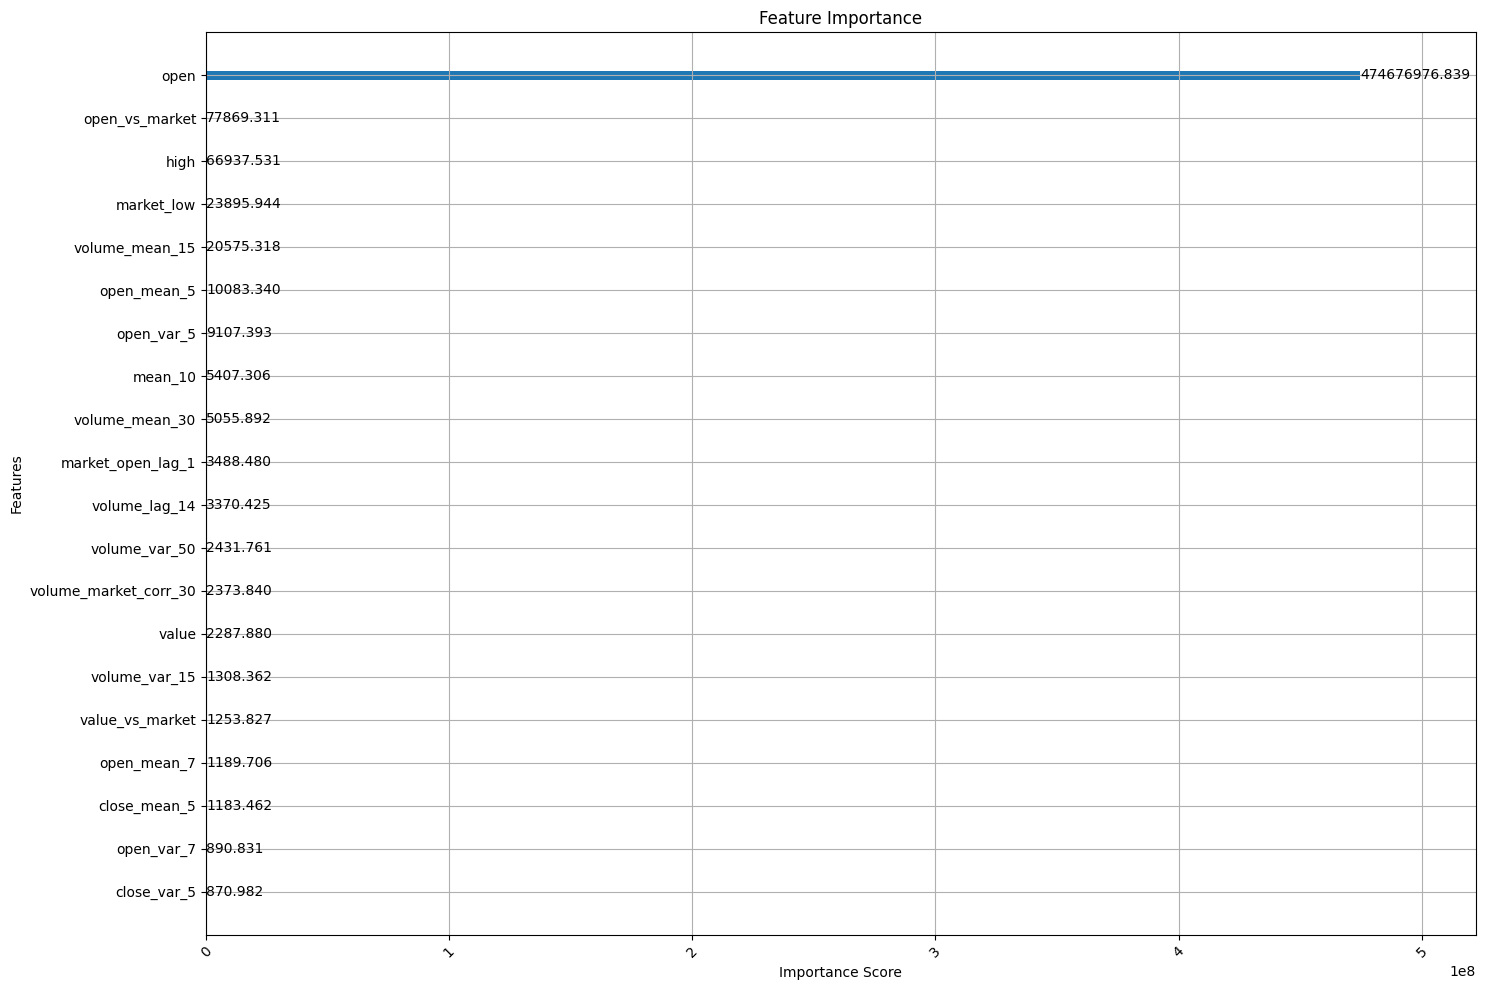

: 

In [ ]:
def model_for_company_maker(df, company):
    
    with open('../data/model_data/model_data_cache.json', 'r', encoding='utf-8') as f:
        sentiment_df = pd.DataFrame(json.load(f))
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df['answer'] = sentiment_df['answer'].apply(int)
    print(f'training model for company: {company}')
    copied_df = add_technical_indicators(df)
    copied_df = add_sentiment_features(copied_df, sentiment_df)
    model, scores = train_and_evaluate_model(copied_df)

    os.makedirs('models', exist_ok=True)
    joblib.dump(model, f'models/{company}_predictive_model.pkl')

    print('для сравнения тренируем модель без сентимента для компании', company)
    
    copied_df = add_technical_indicators(df)
    train_and_evaluate_model(copied_df)



df = pd.read_parquet('../data/moex_new_features.parquet')
df['begin'] = pd.to_datetime(df['begin'])
df['end'] = pd.to_datetime(df['end'])
df = df.sort_values('begin')
print(df.columns)

market_agg = df.groupby('begin').agg({
    'volume': 'sum',
    'value': 'sum',
    'open': 'mean',
    'close': 'mean',
    'high': 'max',
    'low': 'min'
}).reset_index()
market_agg.columns = ['begin', 'market_volume', 'market_value', 'market_open', 'market_close_pred', 'market_high', 'market_low']
df = df.merge(market_agg, on='begin', how='left')

df['day_sin'] = np.sin(2 * np.pi * df['begin'].dt.dayofweek / 7)
df['day_cos'] = np.cos(2 * np.pi * df['begin'].dt.dayofweek / 7)
df['hour_sin'] = np.sin(2 * np.pi * df['begin'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['begin'].dt.hour / 24)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

dfs = []
for df_type in set(df.company):
    dfs.append(df[df['company'] == df_type].drop(columns=['company']))
    model_for_company_maker(dfs[-1], df_type)
    
